# Malware Classifier Technical Report

## Overview
This report outlines the methodologies and results from training machine learning classifiers to detect malware using opcode sequences. The classifiers evaluated include Support Vector Machine (SVM), K-Nearest Neighbors (KNN), and Decision Tree. Key steps such as feature extraction from opcode n-grams, class balancing using ROS and SMOTE, and performance metrics are discussed.


In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

## Data Preparation and Feature Engineering

### `read_opcode_files(base_path)`
- Reads opcode files organized by APT groups, processes them into comma-separated sequences, and saves the data to `opcodes_dataset.csv`.
- Returns a DataFrame with `Opcodes` and `APT` group labels.

### `extract_ngram_features(df, n=1)`
- Extracts n-gram features (1-gram or 2-gram) from the opcode sequences.
- Produces a frequency matrix with rows as samples and columns as unique n-grams or bigrams.
- Returns the frequency matrix and column names.


In [2]:
def read_opcode_files(base_path):
    data = []
    labels = []
    
    # Walk through all directories
    for apt_folder in os.listdir(base_path):
        apt_path = os.path.join(base_path, apt_folder)
        if os.path.isdir(apt_path):
            # Process each file in the APT folder
            for file_path in glob.glob(os.path.join(apt_path, '*')):
                with open(file_path, 'r') as f:
                    # Split by newline and join with commas
                    opcodes = f.read().strip()
                    opcodes = ', '.join(op.strip() for op in opcodes.split('\n') if op.strip())
                    data.append(opcodes)
                    labels.append(apt_folder)
    
    # Create the DataFrame
    df = pd.DataFrame({'Opcodes': data, 'APT': labels})
    
    # Print the first few rows of the DataFrame
    print("Preview of the DataFrame before n-gram extraction:")
    print(df.head())
    
    # Save to CSV
    output_path = 'opcodes_dataset.csv'
    df.to_csv(output_path, index=False)
    print(f"\nDataset saved to: {output_path}")
    
    return df


def extract_ngram_features(df, n=1):
    if n == 1:
        # Get all unique opcodes
        unique_ngrams = set()
        for opcodes in df['Opcodes']:
            unique_ngrams.update(op.strip() for op in opcodes.split(', '))
        
        # Sort the unique opcodes for consistent column ordering
        unique_ngrams = sorted(unique_ngrams)
        
        # Create a DataFrame with opcode frequencies
        ngram_counts_df = pd.DataFrame(0, index=range(len(df)), columns=unique_ngrams)
        
        # Count frequencies for each sample
        for i, row in df.iterrows():
            opcode_list = [op.strip() for op in row['Opcodes'].split(', ')]
            counts = Counter(opcode_list)
            
            for opcode, count in counts.items():
                ngram_counts_df.at[i, opcode] = count
                
    elif n == 2:
        # Get all unique bigrams from the entire dataset first
        all_bigrams = set()
        for opcodes in df['Opcodes']:
            opcode_list = [op.strip() for op in opcodes.split(', ')]
            bigrams = list(zip(opcode_list[:-1], opcode_list[1:]))
            bigram_strings = [f"{b[0]}_{b[1]}" for b in bigrams]
            all_bigrams.update(bigram_strings)
        
        # Sort the unique bigrams for consistent column ordering
        unique_bigrams = sorted(all_bigrams)
        
        # Create a DataFrame with bigram frequencies
        ngram_counts_df = pd.DataFrame(0, index=range(len(df)), columns=unique_bigrams)
        
        # Count frequencies for each sample
        for i, row in df.iterrows():
            opcode_list = [op.strip() for op in row['Opcodes'].split(', ')]
            bigrams = list(zip(opcode_list[:-1], opcode_list[1:]))
            bigram_strings = [f"{b[0]}_{b[1]}" for b in bigrams]
            counts = Counter(bigram_strings)
            
            for bigram, count in counts.items():
                ngram_counts_df.at[i, bigram] = count
    
    print(f"First few rows of the {n}-gram frequency feature matrix:")
    print(ngram_counts_df.head())
    
    return ngram_counts_df.values, ngram_counts_df.columns.tolist()

## Label Encoding and Feature Extraction

1. **Set Base Path**:
   - Specifies the directory containing opcode files for processing.

2. **Read and Process Opcode Files**:
   - `df = read_opcode_files(base_path)`: Reads opcode sequences and APT labels into a DataFrame.

3. **Feature Extraction**:
   - Extracts 1-gram and 2-gram features using `extract_ngram_features(df, n=1)` and `n=2`.
   - Combines the features into a single matrix using `np.concatenate`.

4. **Label Encoding**:
   - Encodes APT group labels into numeric form using `LabelEncoder`.

5. **Print Feature and Class Information**:
   - Displays the shapes of 1-gram, 2-gram, and combined feature matrices, along with the number of unique classes.

6. **Data Splitting**:
   - Splits the combined features and labels into training and testing sets for classification.


In [3]:
base_path = '/Users/jeffreyjeyachandren/Desktop/opscode_ml/opcodes'  #opscode folder path
df = read_opcode_files(base_path)

# Get features
X_1gram, cols_1gram = extract_ngram_features(df, n=1)
X_2gram, cols_2gram = extract_ngram_features(df, n=2)

# Combine features
X = np.concatenate([X_1gram, X_2gram], axis=1)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['APT'])

# Print shape information
print(f"Shape of 1-gram features: {X_1gram.shape}")
print(f"Shape of 2-gram features: {X_2gram.shape}")
print(f"Shape of combined features: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")


Preview of the DataFrame before n-gram extraction:
                                             Opcodes            APT
0  JMP, JMP, JMP, JMP, JMP, JMP, JMP, JMP, POP, P...        Evilnum
1  PUSH, MOV, MOV, CALL, PUSH, PUSH, PUSH, PUSH, ...  APT19_opcodes
2  MOV, PUSH, MOV, CALL, TEST, PUSH, CALL, ADD, M...  APT19_opcodes
3  PUSH, PUSH, PUSH, MOV, CMP, JE, CMP, JNE, PUSH...  APT19_opcodes
4  PUSH, PUSH, PUSH, MOV, CMP, JE, CMP, JNE, PUSH...  APT19_opcodes

Dataset saved to: opcodes_dataset.csv
First few rows of the 1-gram frequency feature matrix:
   A  AA  AAA  AAD  AAM  AAS  AB  ABCBFFFF  ABDAFFFF  ABFDFFFF  ...  X  XADD  \
0  0   0    0    0    0    0   0         0         0         0  ...  0     0   
1  0   0    0    0    0    0   0         0         0         0  ...  0     0   
2  0   0    0    0    0    0   0         0         0         0  ...  0     0   
3  0   0    0    0    0    0   0         0         0         0  ...  0     0   
4  0   0    0    0    0    0   0         0     

## Model Training and Evaluation

1. **Data Splitting**:
   - Splits the combined feature matrix and labels into training and testing sets using `train_test_split`.

2. **Initialize Classifiers**:
   - Defines a set of classifiers:
     - Support Vector Machine (SVM)
     - K-Nearest Neighbors (KNN) with k=3 and k=5
     - Decision Tree

3. **Training and Prediction**:
   - Trains each classifier on the training data.
   - Makes predictions on the test set.

4. **Evaluation**:
   - Calculates accuracy using `accuracy_score`.
   - Generates detailed classification reports using `classification_report` with class labels mapped back to APT group names.

5. **Results**:
   - Stores accuracy and classification reports for each classifier in a results dictionary.


In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    'SVM': SVC(kernel='rbf'),
    'KNN-3': KNeighborsClassifier(n_neighbors=3),
    'KNN-5': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier()
}

# Train and evaluate classifiers
results = {}
for name, clf in classifiers.items():
    # Train
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
        # Get unique classes present in the test set
    unique_classes = np.unique(y_test)
    target_names = le.inverse_transform(unique_classes)
    
    # Generate classification report
    report = classification_report(y_test, y_pred, 
                                 labels=unique_classes,
                                 target_names=target_names)
    
    results[name] = {
        'accuracy': accuracy,
        'report': report
    }

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Results

## Classifier Evaluation and Comparison

### Key Functions and Processes:

1. **`evaluate_classifier`**:
   - Trains a classifier, evaluates its performance, and visualizes results.
   - Metrics calculated:
     - Accuracy, Precision, Recall, F1-Score (weighted average and per class).
   - Outputs:
     - Classification report.
     - Confusion matrix heatmap.
     - Per-class metrics (precision, recall, F1-score, support).

2. **Feature Scaling**:
   - Scales 1-gram, 2-gram, and combined features using `StandardScaler` for consistent performance across classifiers.

3. **Classifier Initialization**:
   - Includes:
     - SVM (balanced class weights).
     - KNN with k=3 and k=5.
     - Decision Tree (balanced class weights).

4. **Evaluation Pipeline**:
   - Loops through feature types (`1gram`, `2gram`, `combined`) and classifiers.
   - Splits data into training and test sets for each feature type.
   - Calls `evaluate_classifier` to train, predict, and visualize results.

5. **Metric Comparison Plot**:
   - Compares Accuracy, Precision, Recall, and F1-score across feature types and classifiers.
   - Visualized using grouped bar charts.

### Outputs:
- Detailed metrics for each classifier and feature type.
- Visual confusion matrices for each model.
- Comparative bar charts showing performance metrics across classifiers and feature types.



Evaluating 1gram features:
SVM Results:
Accuracy: 0.1163

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       1.00      0.33      0.50         6
           6       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         1
          22       0.25      0.18      0.21        11

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

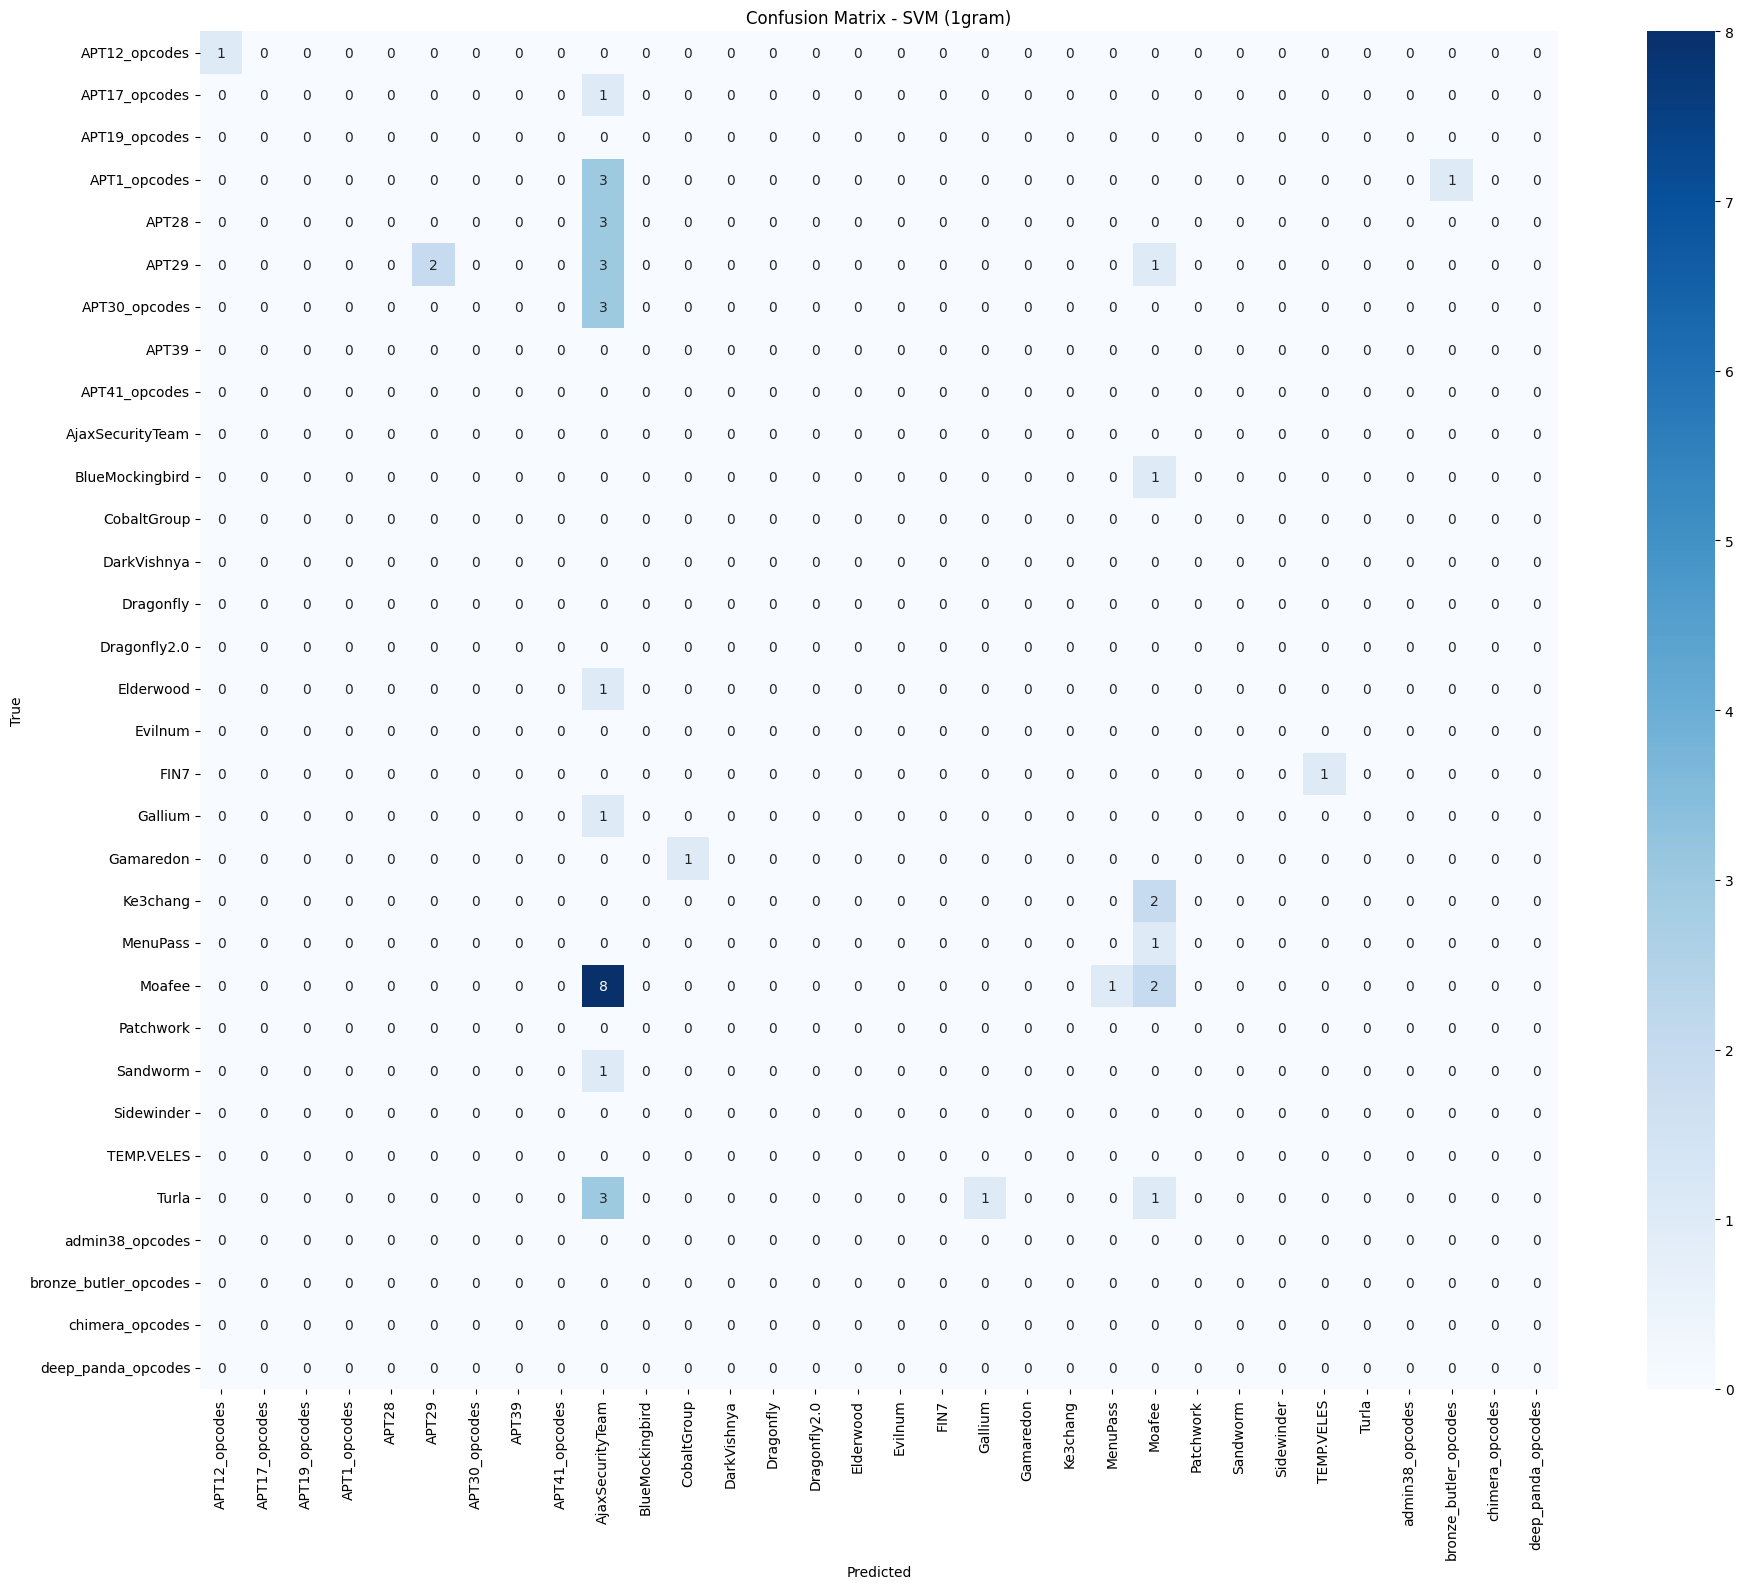


Per-class Metrics:
--------------------------------------------------------------------------------
Class                           Precision     Recall   F1-score    Support
--------------------------------------------------------------------------------
APT12_opcodes                      1.0000     1.0000     1.0000          1
APT17_opcodes                      0.0000     0.0000     0.0000          1
APT19_opcodes                      0.0000     0.0000     0.0000          0
APT1_opcodes                       0.0000     0.0000     0.0000          4
APT28                              0.0000     0.0000     0.0000          3
APT29                              1.0000     0.3333     0.5000          6
APT30_opcodes                      0.0000     0.0000     0.0000          3
APT39                              0.0000     0.0000     0.0000          0
APT41_opcodes                      0.0000     0.0000     0.0000          0
AjaxSecurityTeam                   0.0000     0.0000     0.0000     

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

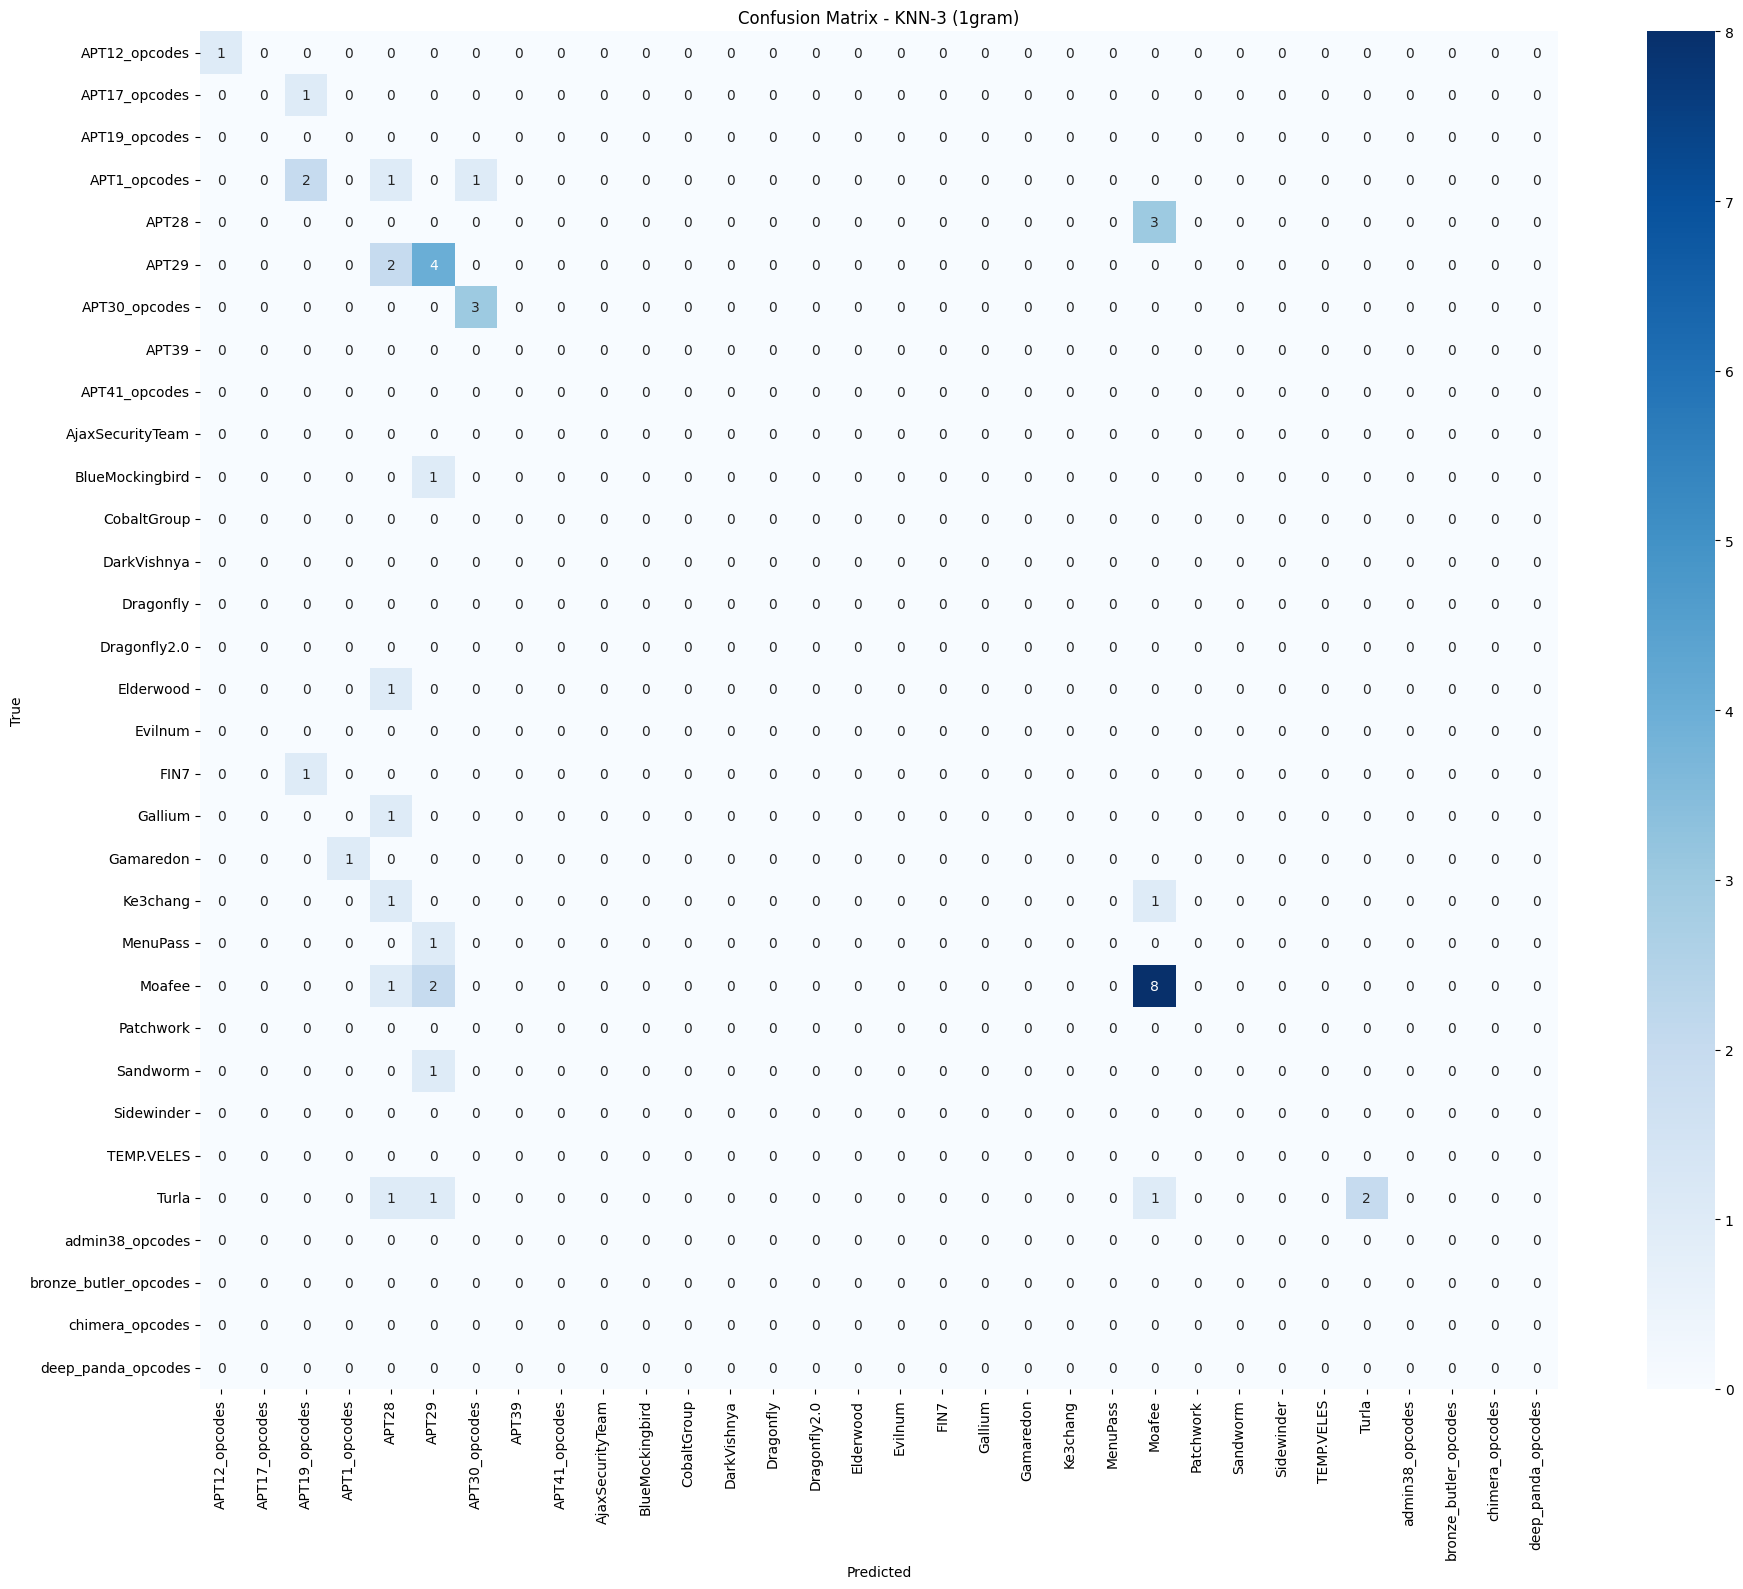


Per-class Metrics:
--------------------------------------------------------------------------------
Class                           Precision     Recall   F1-score    Support
--------------------------------------------------------------------------------
APT12_opcodes                      1.0000     1.0000     1.0000          1
APT17_opcodes                      0.0000     0.0000     0.0000          1
APT19_opcodes                      0.0000     0.0000     0.0000          0
APT1_opcodes                       0.0000     0.0000     0.0000          4
APT28                              0.0000     0.0000     0.0000          3
APT29                              0.4000     0.6667     0.5000          6
APT30_opcodes                      0.7500     1.0000     0.8571          3
APT39                              0.0000     0.0000     0.0000          0
APT41_opcodes                      0.0000     0.0000     0.0000          0
AjaxSecurityTeam                   0.0000     0.0000     0.0000     

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

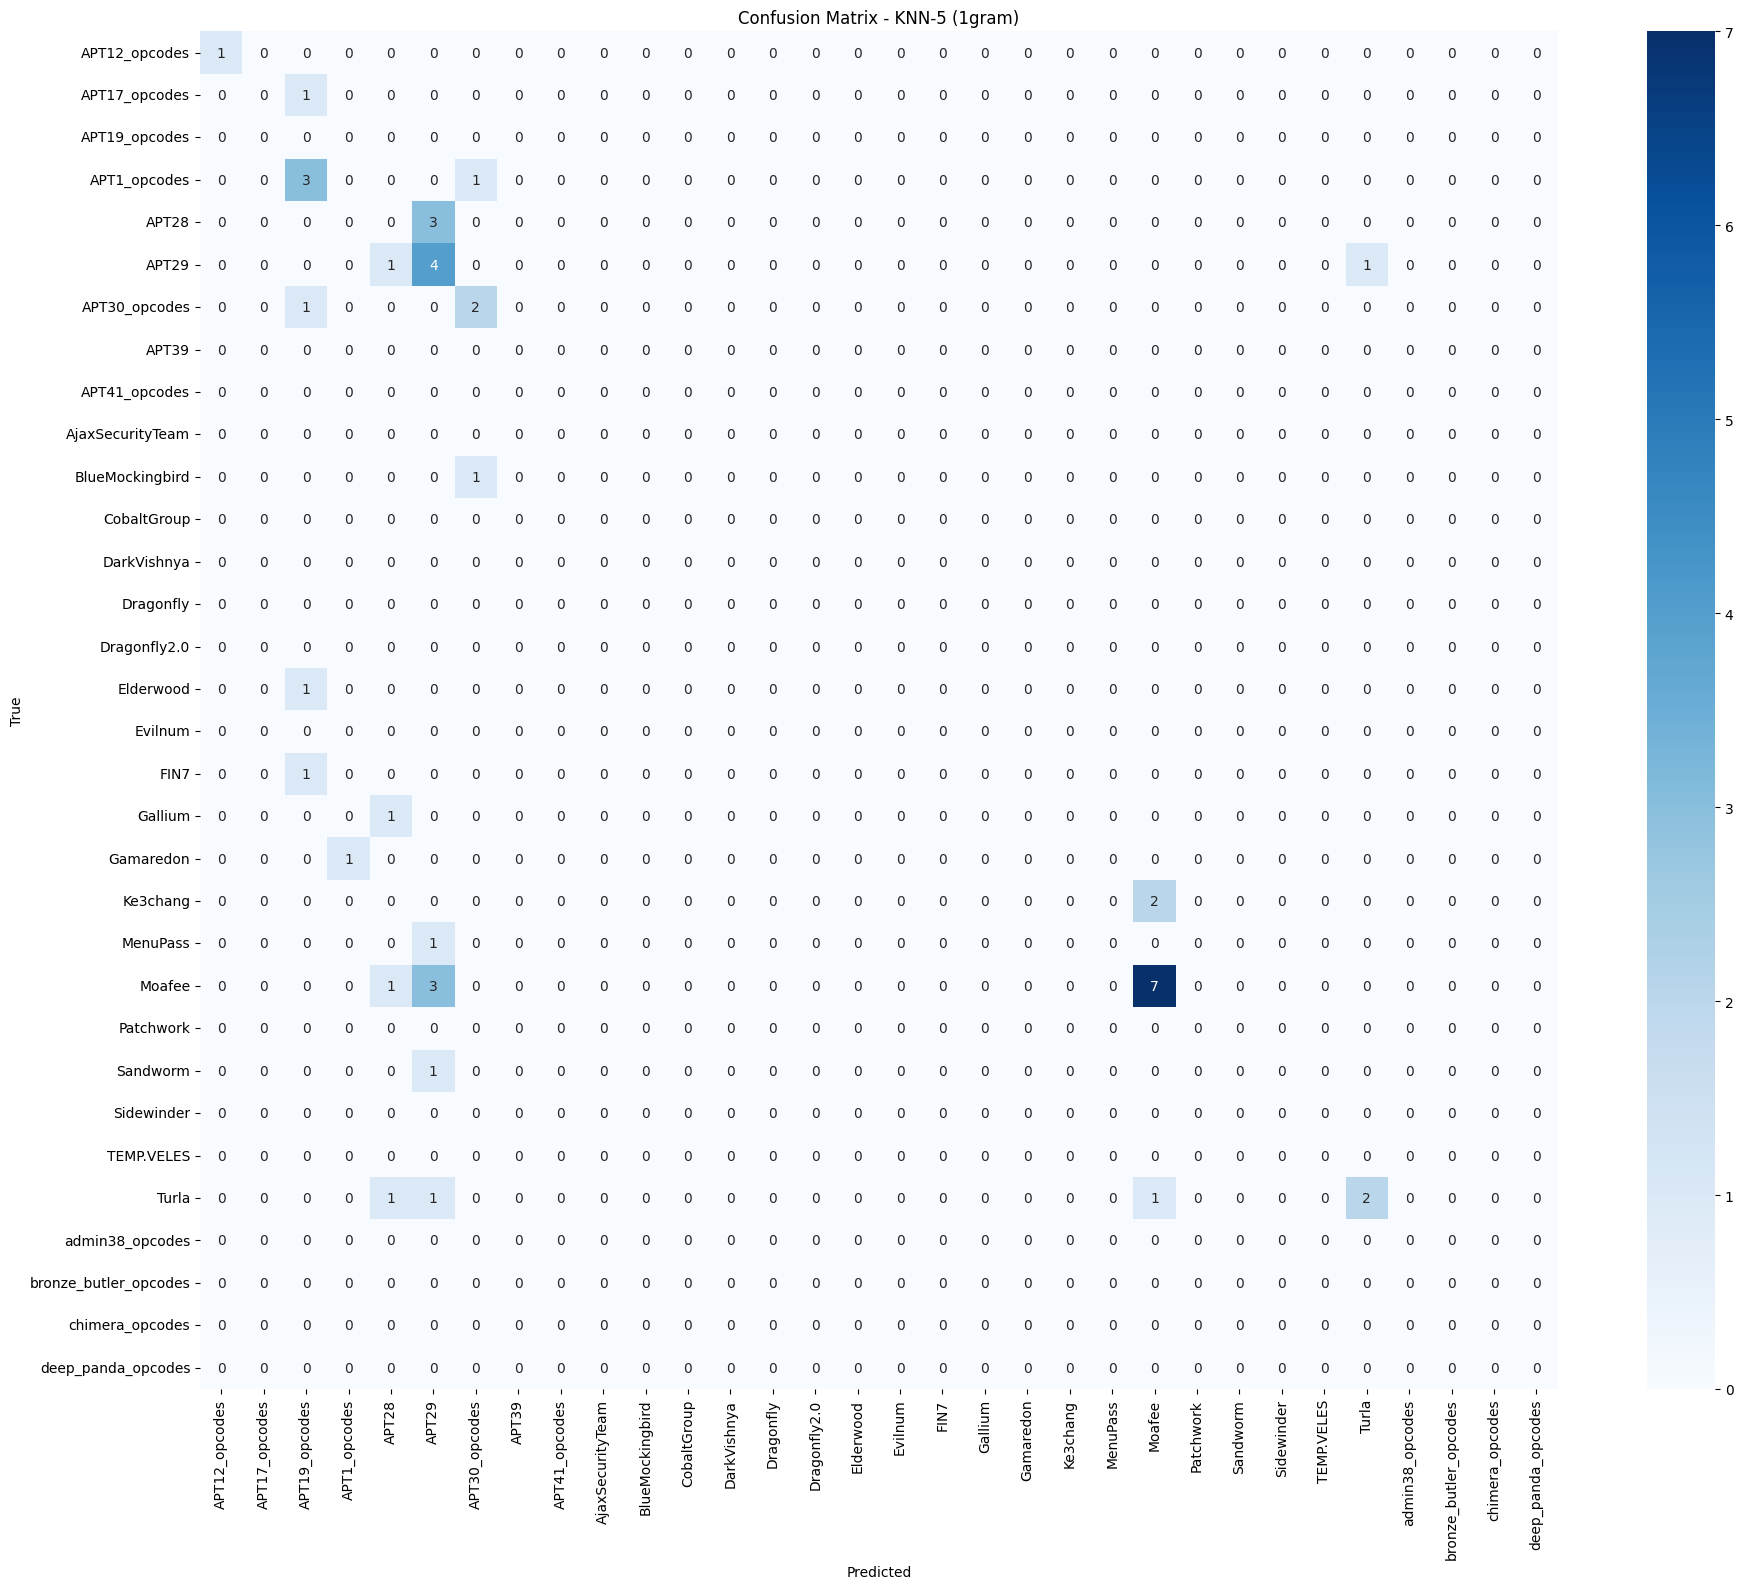


Per-class Metrics:
--------------------------------------------------------------------------------
Class                           Precision     Recall   F1-score    Support
--------------------------------------------------------------------------------
APT12_opcodes                      1.0000     1.0000     1.0000          1
APT17_opcodes                      0.0000     0.0000     0.0000          1
APT19_opcodes                      0.0000     0.0000     0.0000          0
APT1_opcodes                       0.0000     0.0000     0.0000          4
APT28                              0.0000     0.0000     0.0000          3
APT29                              0.3077     0.6667     0.4211          6
APT30_opcodes                      0.5000     0.6667     0.5714          3
APT39                              0.0000     0.0000     0.0000          0
APT41_opcodes                      0.0000     0.0000     0.0000          0
AjaxSecurityTeam                   0.0000     0.0000     0.0000     

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

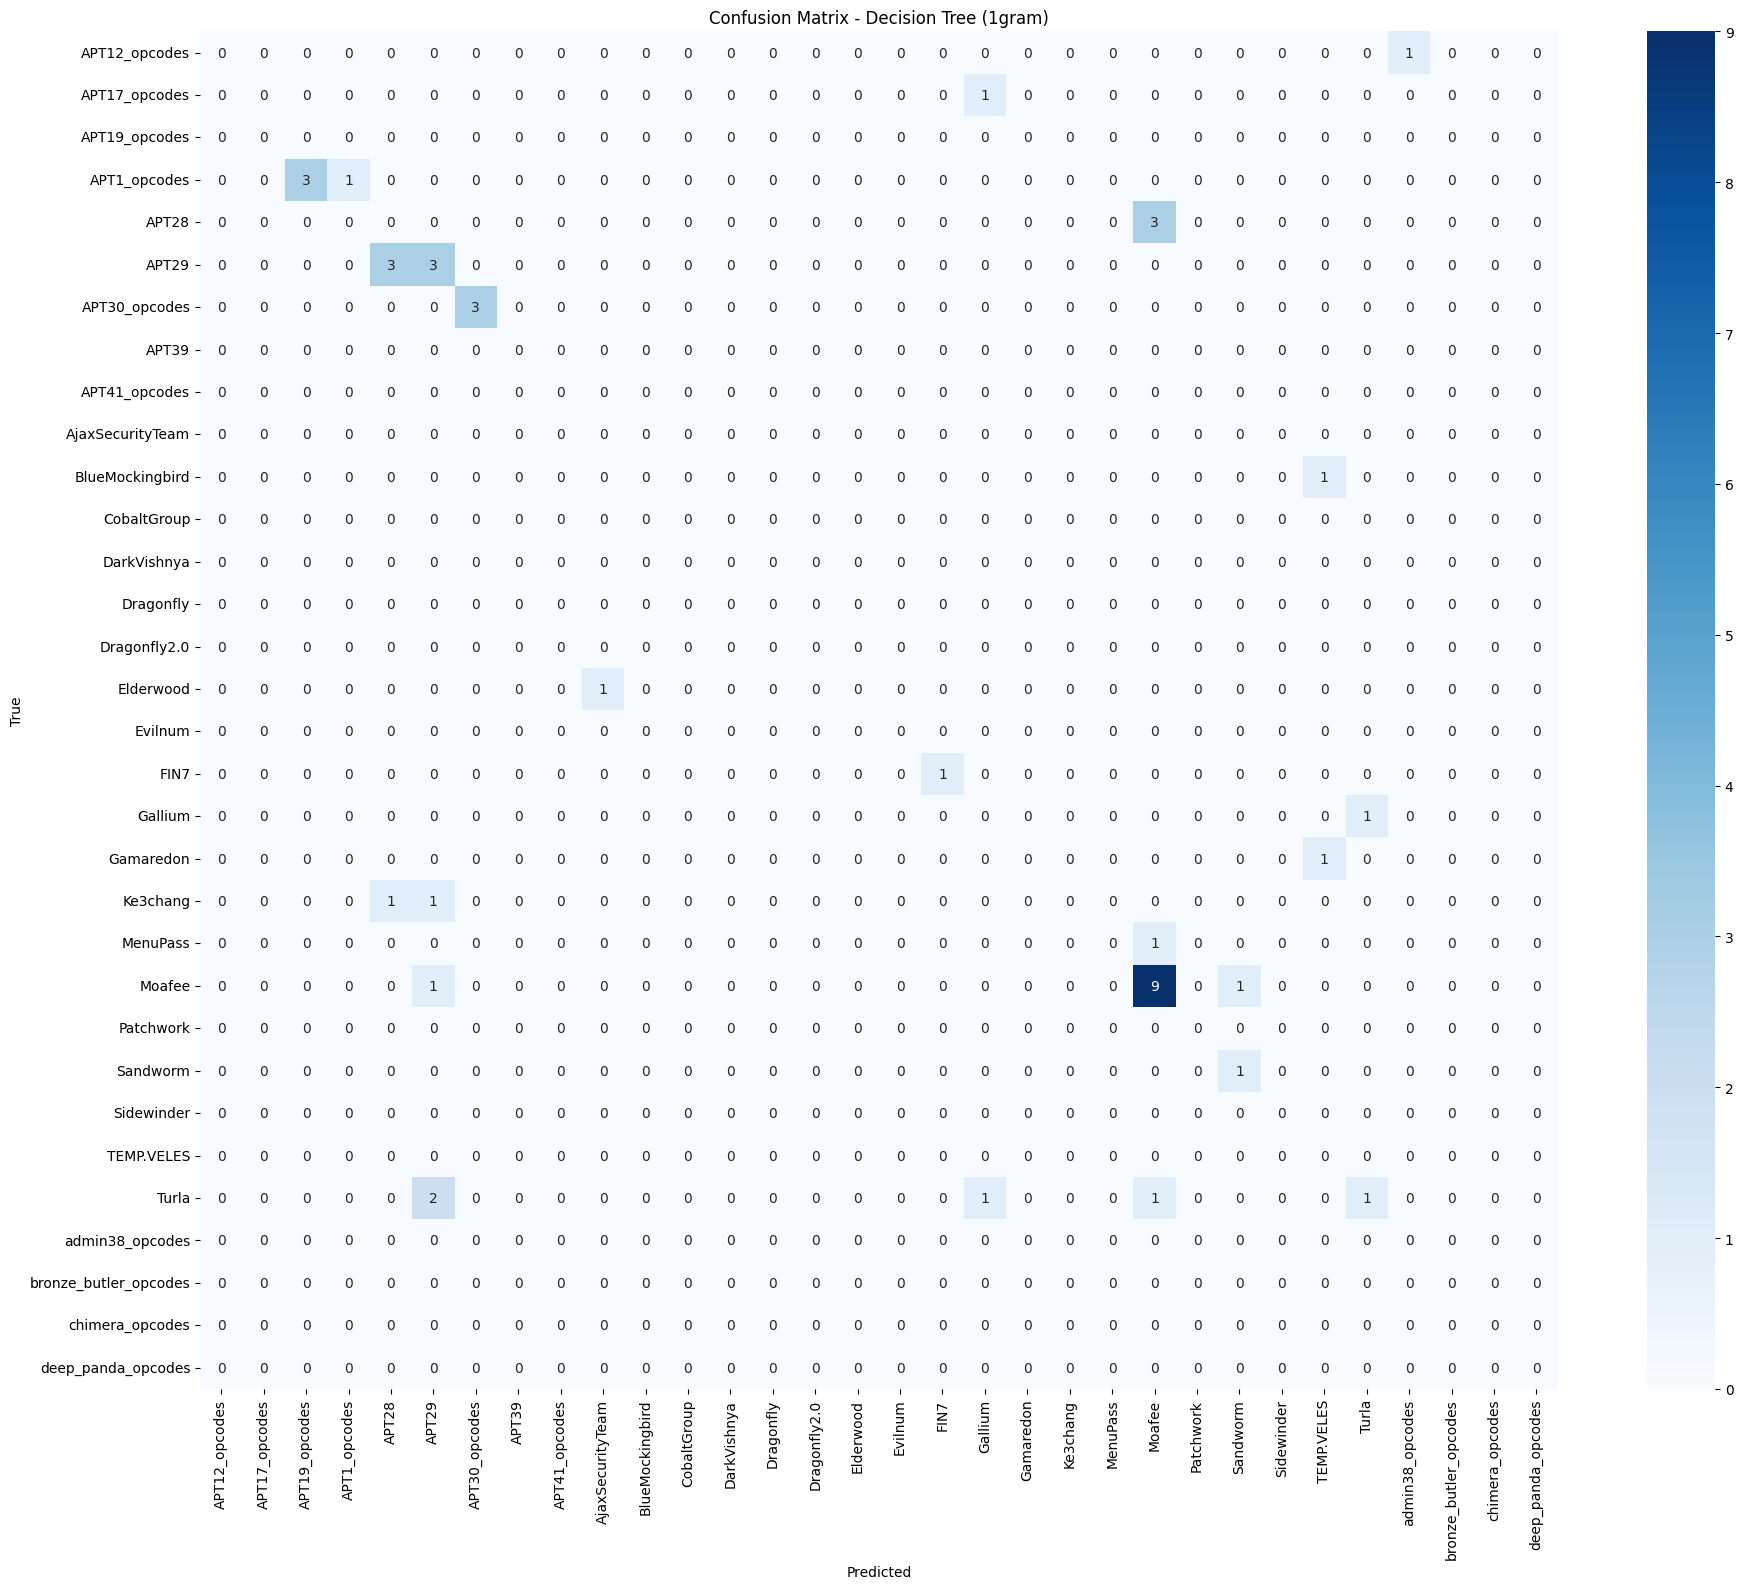


Per-class Metrics:
--------------------------------------------------------------------------------
Class                           Precision     Recall   F1-score    Support
--------------------------------------------------------------------------------
APT12_opcodes                      0.0000     0.0000     0.0000          1
APT17_opcodes                      0.0000     0.0000     0.0000          1
APT19_opcodes                      0.0000     0.0000     0.0000          0
APT1_opcodes                       1.0000     0.2500     0.4000          4
APT28                              0.0000     0.0000     0.0000          3
APT29                              0.4286     0.5000     0.4615          6
APT30_opcodes                      1.0000     1.0000     1.0000          3
APT39                              0.0000     0.0000     0.0000          0
APT41_opcodes                      0.0000     0.0000     0.0000          0
AjaxSecurityTeam                   0.0000     0.0000     0.0000     

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

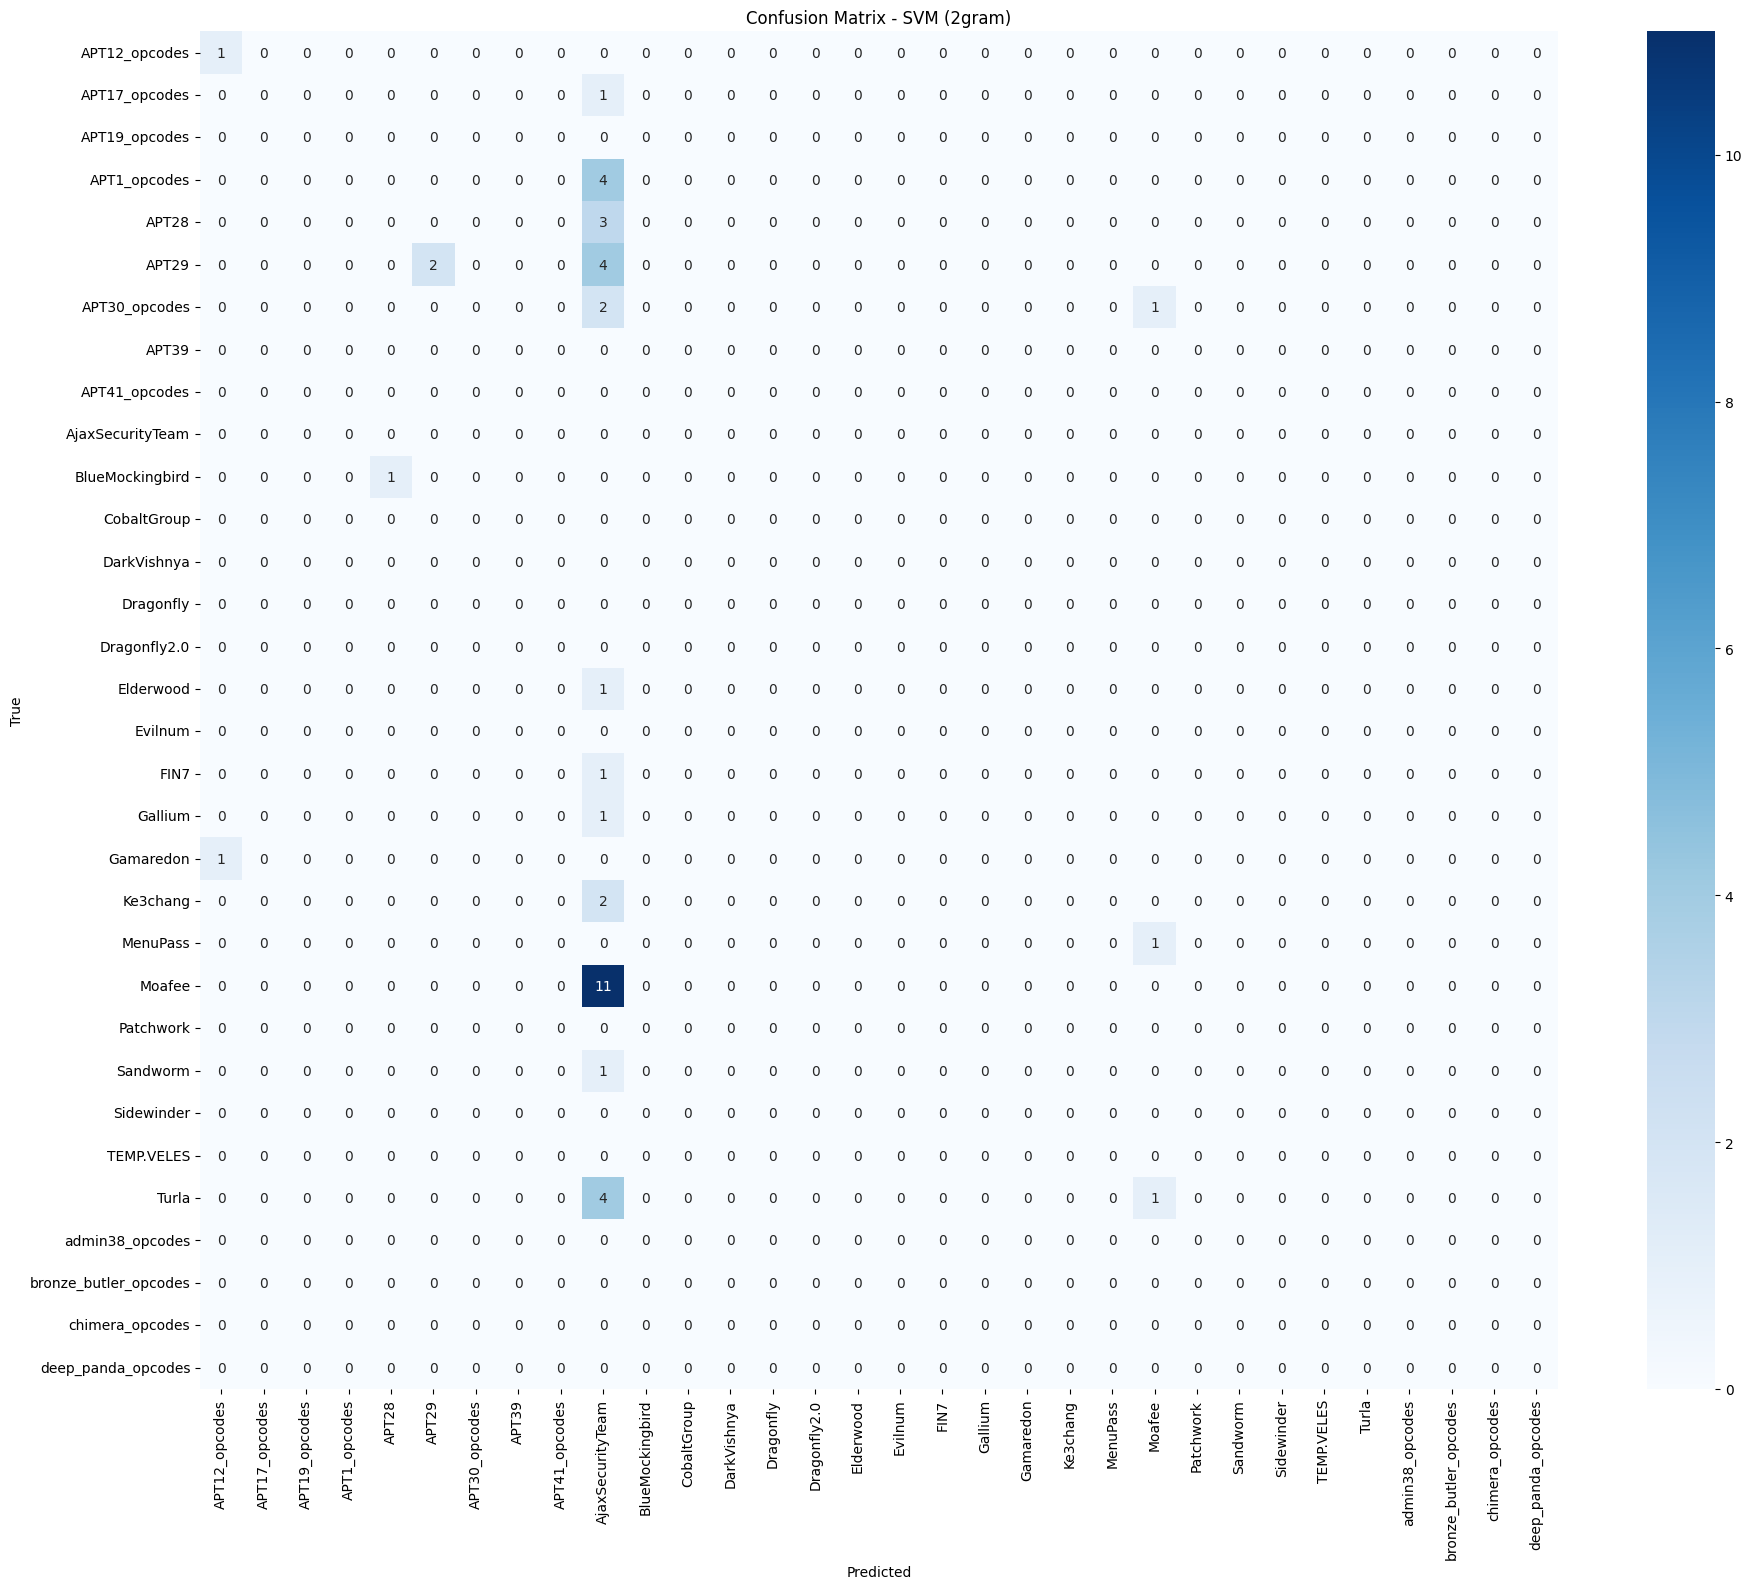


Per-class Metrics:
--------------------------------------------------------------------------------
Class                           Precision     Recall   F1-score    Support
--------------------------------------------------------------------------------
APT12_opcodes                      0.5000     1.0000     0.6667          1
APT17_opcodes                      0.0000     0.0000     0.0000          1
APT19_opcodes                      0.0000     0.0000     0.0000          0
APT1_opcodes                       0.0000     0.0000     0.0000          4
APT28                              0.0000     0.0000     0.0000          3
APT29                              1.0000     0.3333     0.5000          6
APT30_opcodes                      0.0000     0.0000     0.0000          3
APT39                              0.0000     0.0000     0.0000          0
APT41_opcodes                      0.0000     0.0000     0.0000          0
AjaxSecurityTeam                   0.0000     0.0000     0.0000     

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

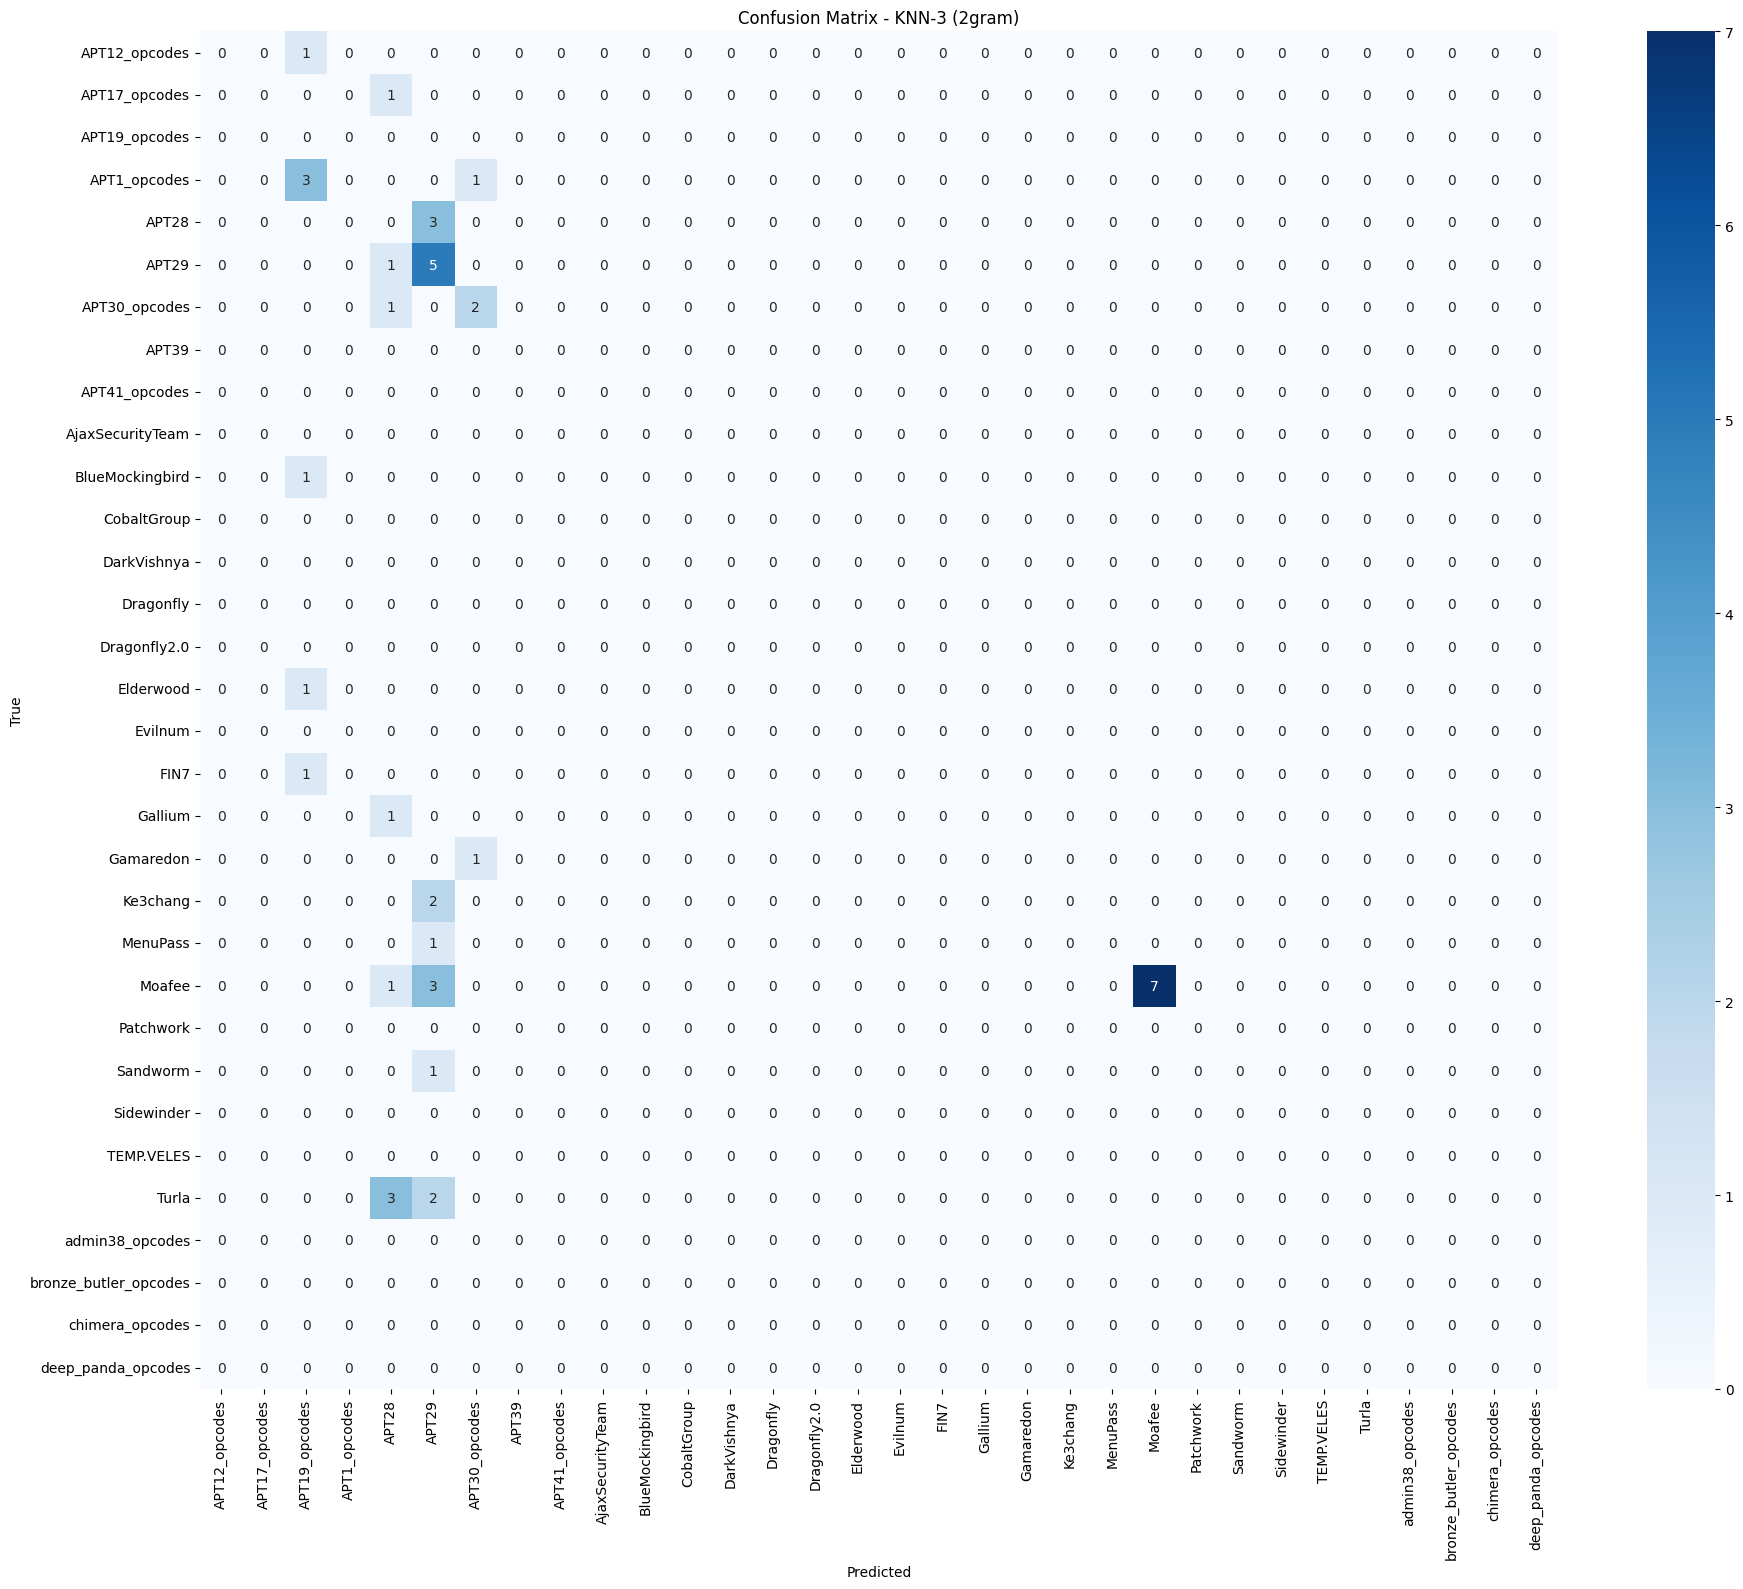


Per-class Metrics:
--------------------------------------------------------------------------------
Class                           Precision     Recall   F1-score    Support
--------------------------------------------------------------------------------
APT12_opcodes                      0.0000     0.0000     0.0000          1
APT17_opcodes                      0.0000     0.0000     0.0000          1
APT19_opcodes                      0.0000     0.0000     0.0000          0
APT1_opcodes                       0.0000     0.0000     0.0000          4
APT28                              0.0000     0.0000     0.0000          3
APT29                              0.2941     0.8333     0.4348          6
APT30_opcodes                      0.5000     0.6667     0.5714          3
APT39                              0.0000     0.0000     0.0000          0
APT41_opcodes                      0.0000     0.0000     0.0000          0
AjaxSecurityTeam                   0.0000     0.0000     0.0000     

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

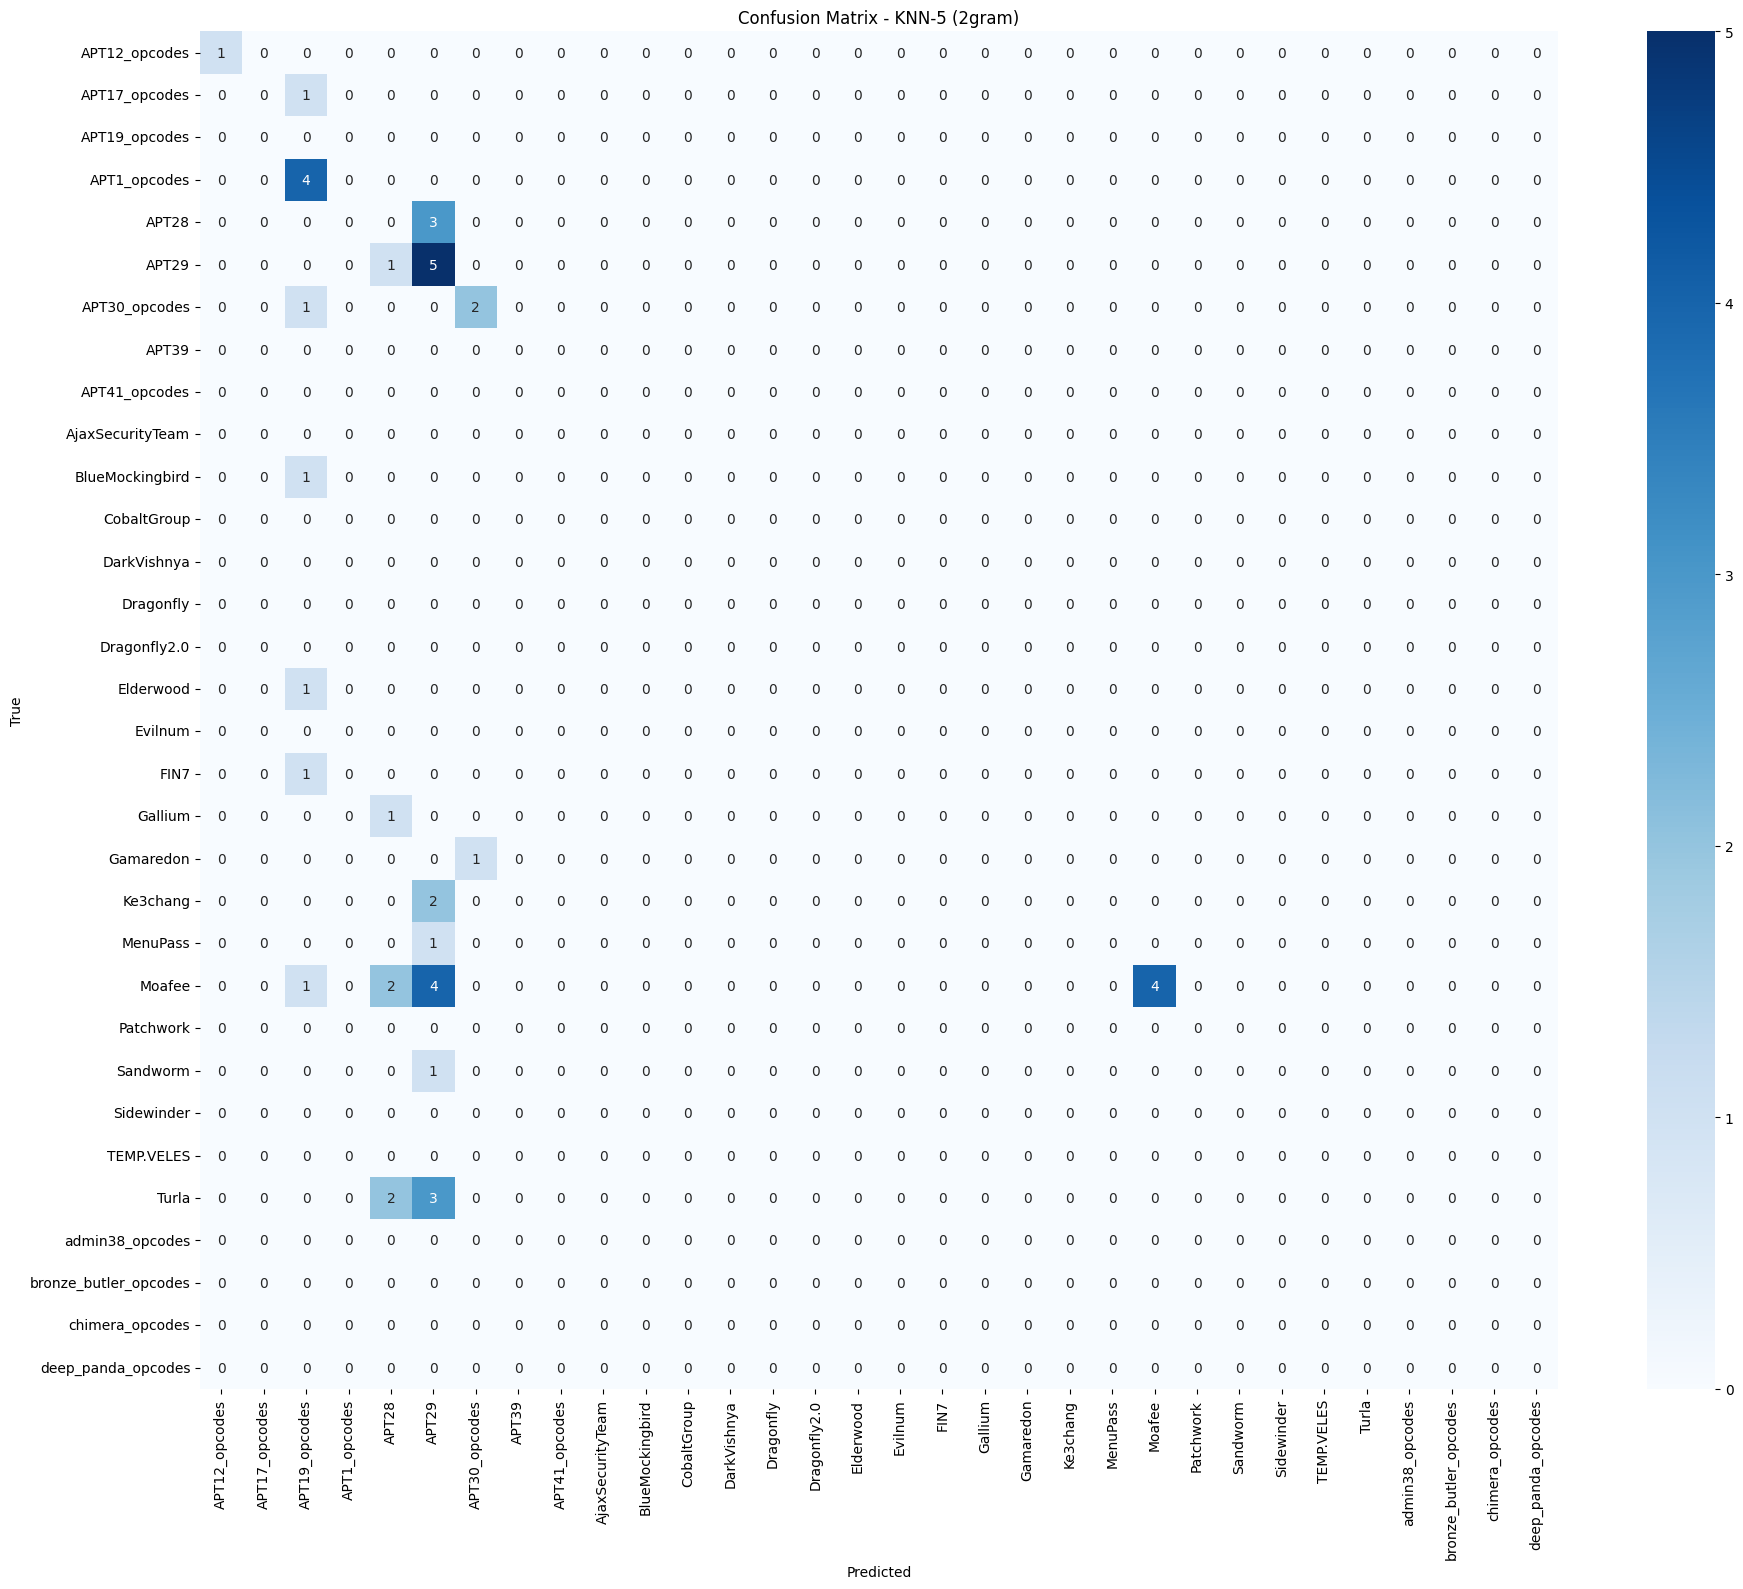


Per-class Metrics:
--------------------------------------------------------------------------------
Class                           Precision     Recall   F1-score    Support
--------------------------------------------------------------------------------
APT12_opcodes                      1.0000     1.0000     1.0000          1
APT17_opcodes                      0.0000     0.0000     0.0000          1
APT19_opcodes                      0.0000     0.0000     0.0000          0
APT1_opcodes                       0.0000     0.0000     0.0000          4
APT28                              0.0000     0.0000     0.0000          3
APT29                              0.2632     0.8333     0.4000          6
APT30_opcodes                      0.6667     0.6667     0.6667          3
APT39                              0.0000     0.0000     0.0000          0
APT41_opcodes                      0.0000     0.0000     0.0000          0
AjaxSecurityTeam                   0.0000     0.0000     0.0000     

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

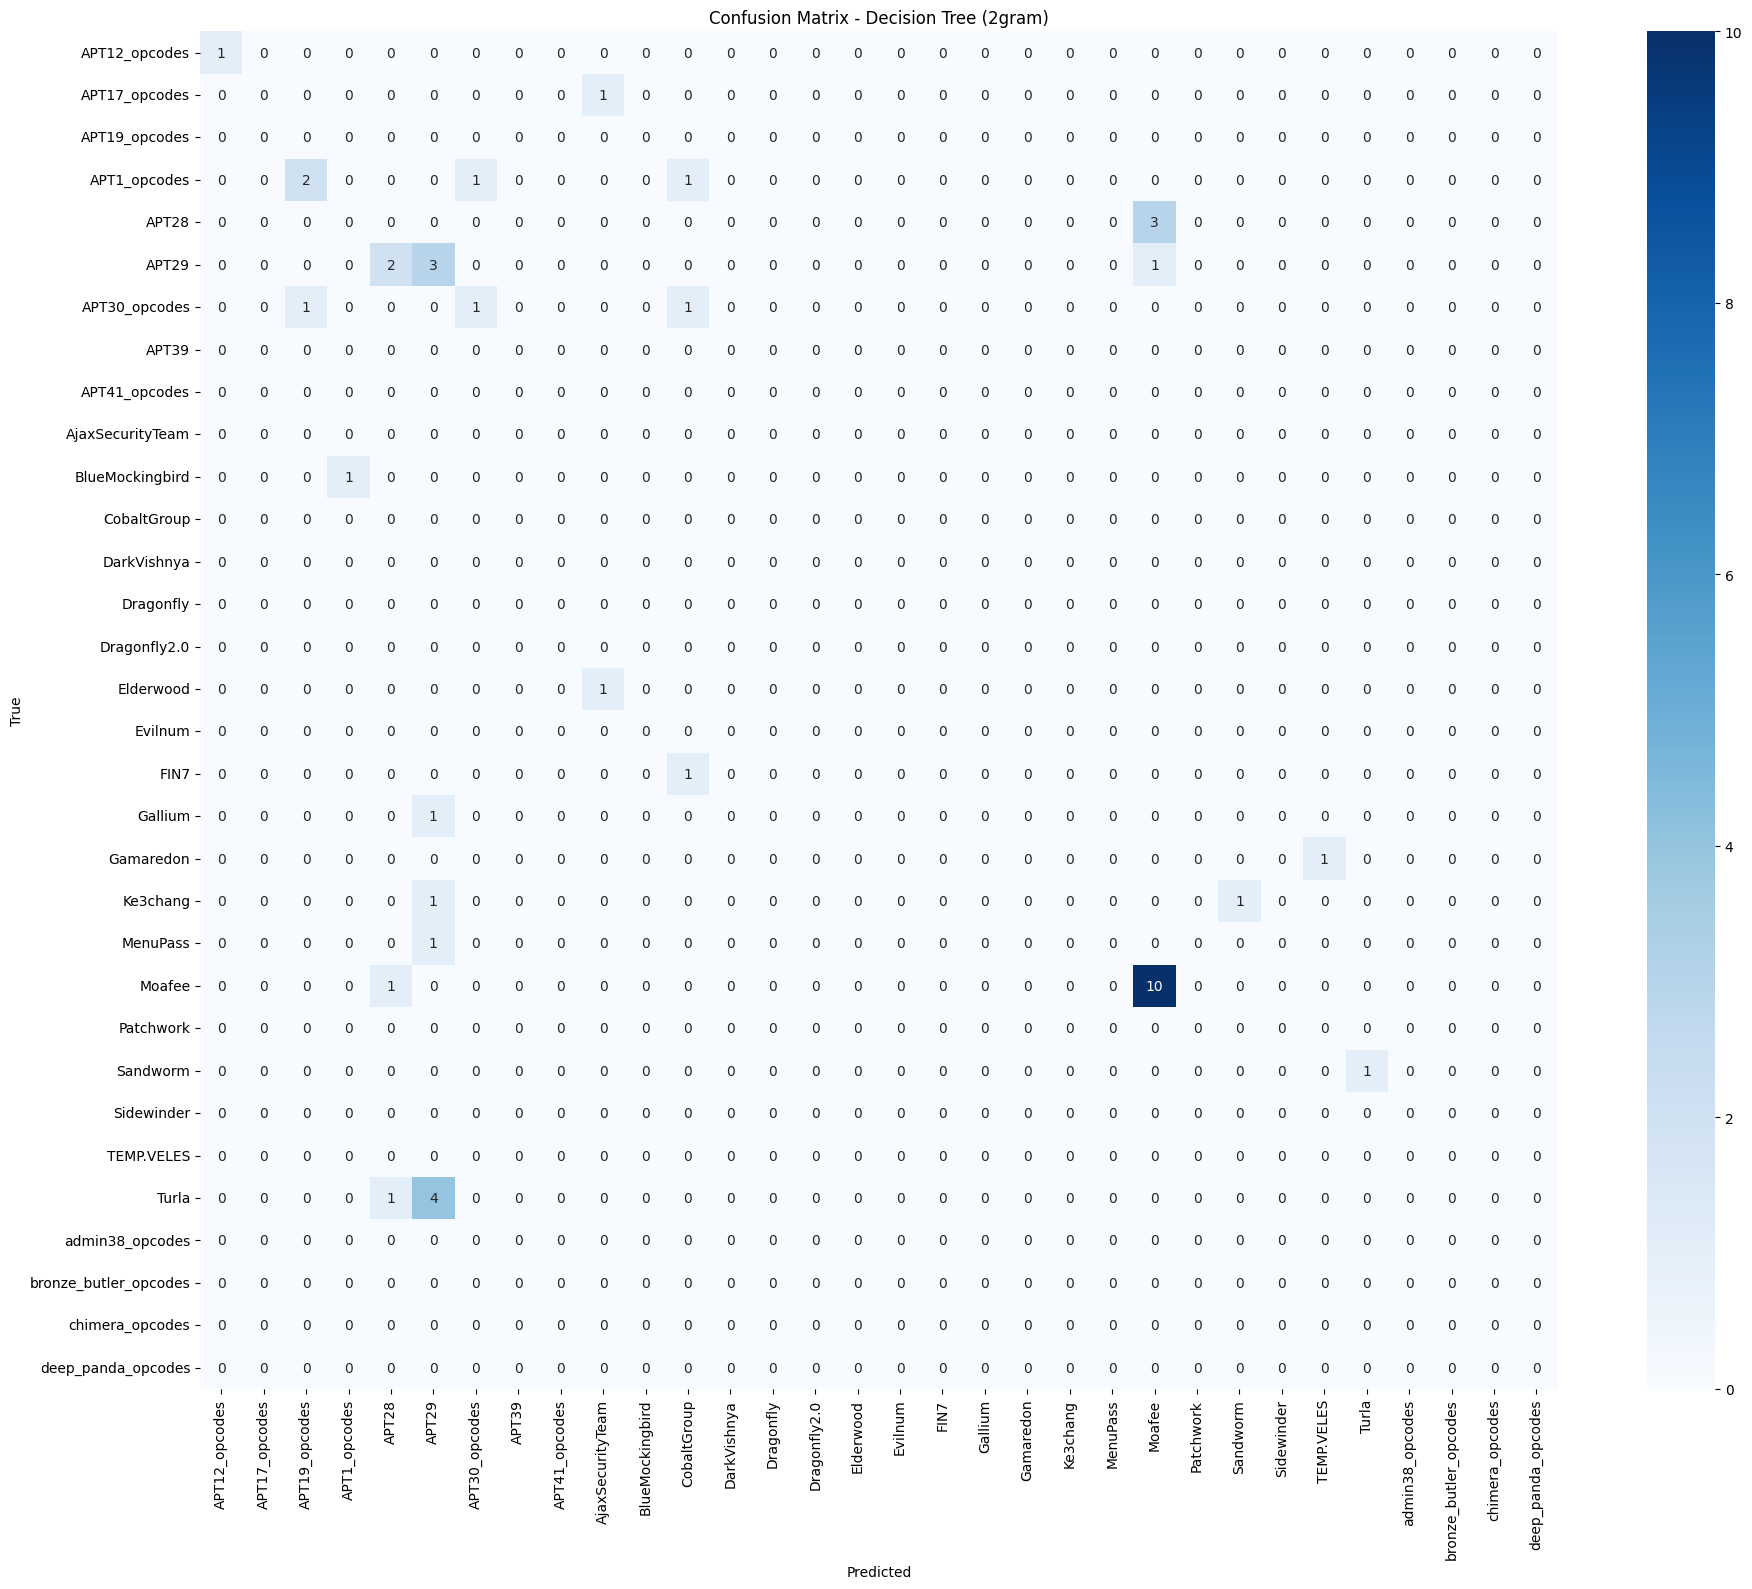


Per-class Metrics:
--------------------------------------------------------------------------------
Class                           Precision     Recall   F1-score    Support
--------------------------------------------------------------------------------
APT12_opcodes                      1.0000     1.0000     1.0000          1
APT17_opcodes                      0.0000     0.0000     0.0000          1
APT19_opcodes                      0.0000     0.0000     0.0000          0
APT1_opcodes                       0.0000     0.0000     0.0000          4
APT28                              0.0000     0.0000     0.0000          3
APT29                              0.3000     0.5000     0.3750          6
APT30_opcodes                      0.5000     0.3333     0.4000          3
APT39                              0.0000     0.0000     0.0000          0
APT41_opcodes                      0.0000     0.0000     0.0000          0
AjaxSecurityTeam                   0.0000     0.0000     0.0000     

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

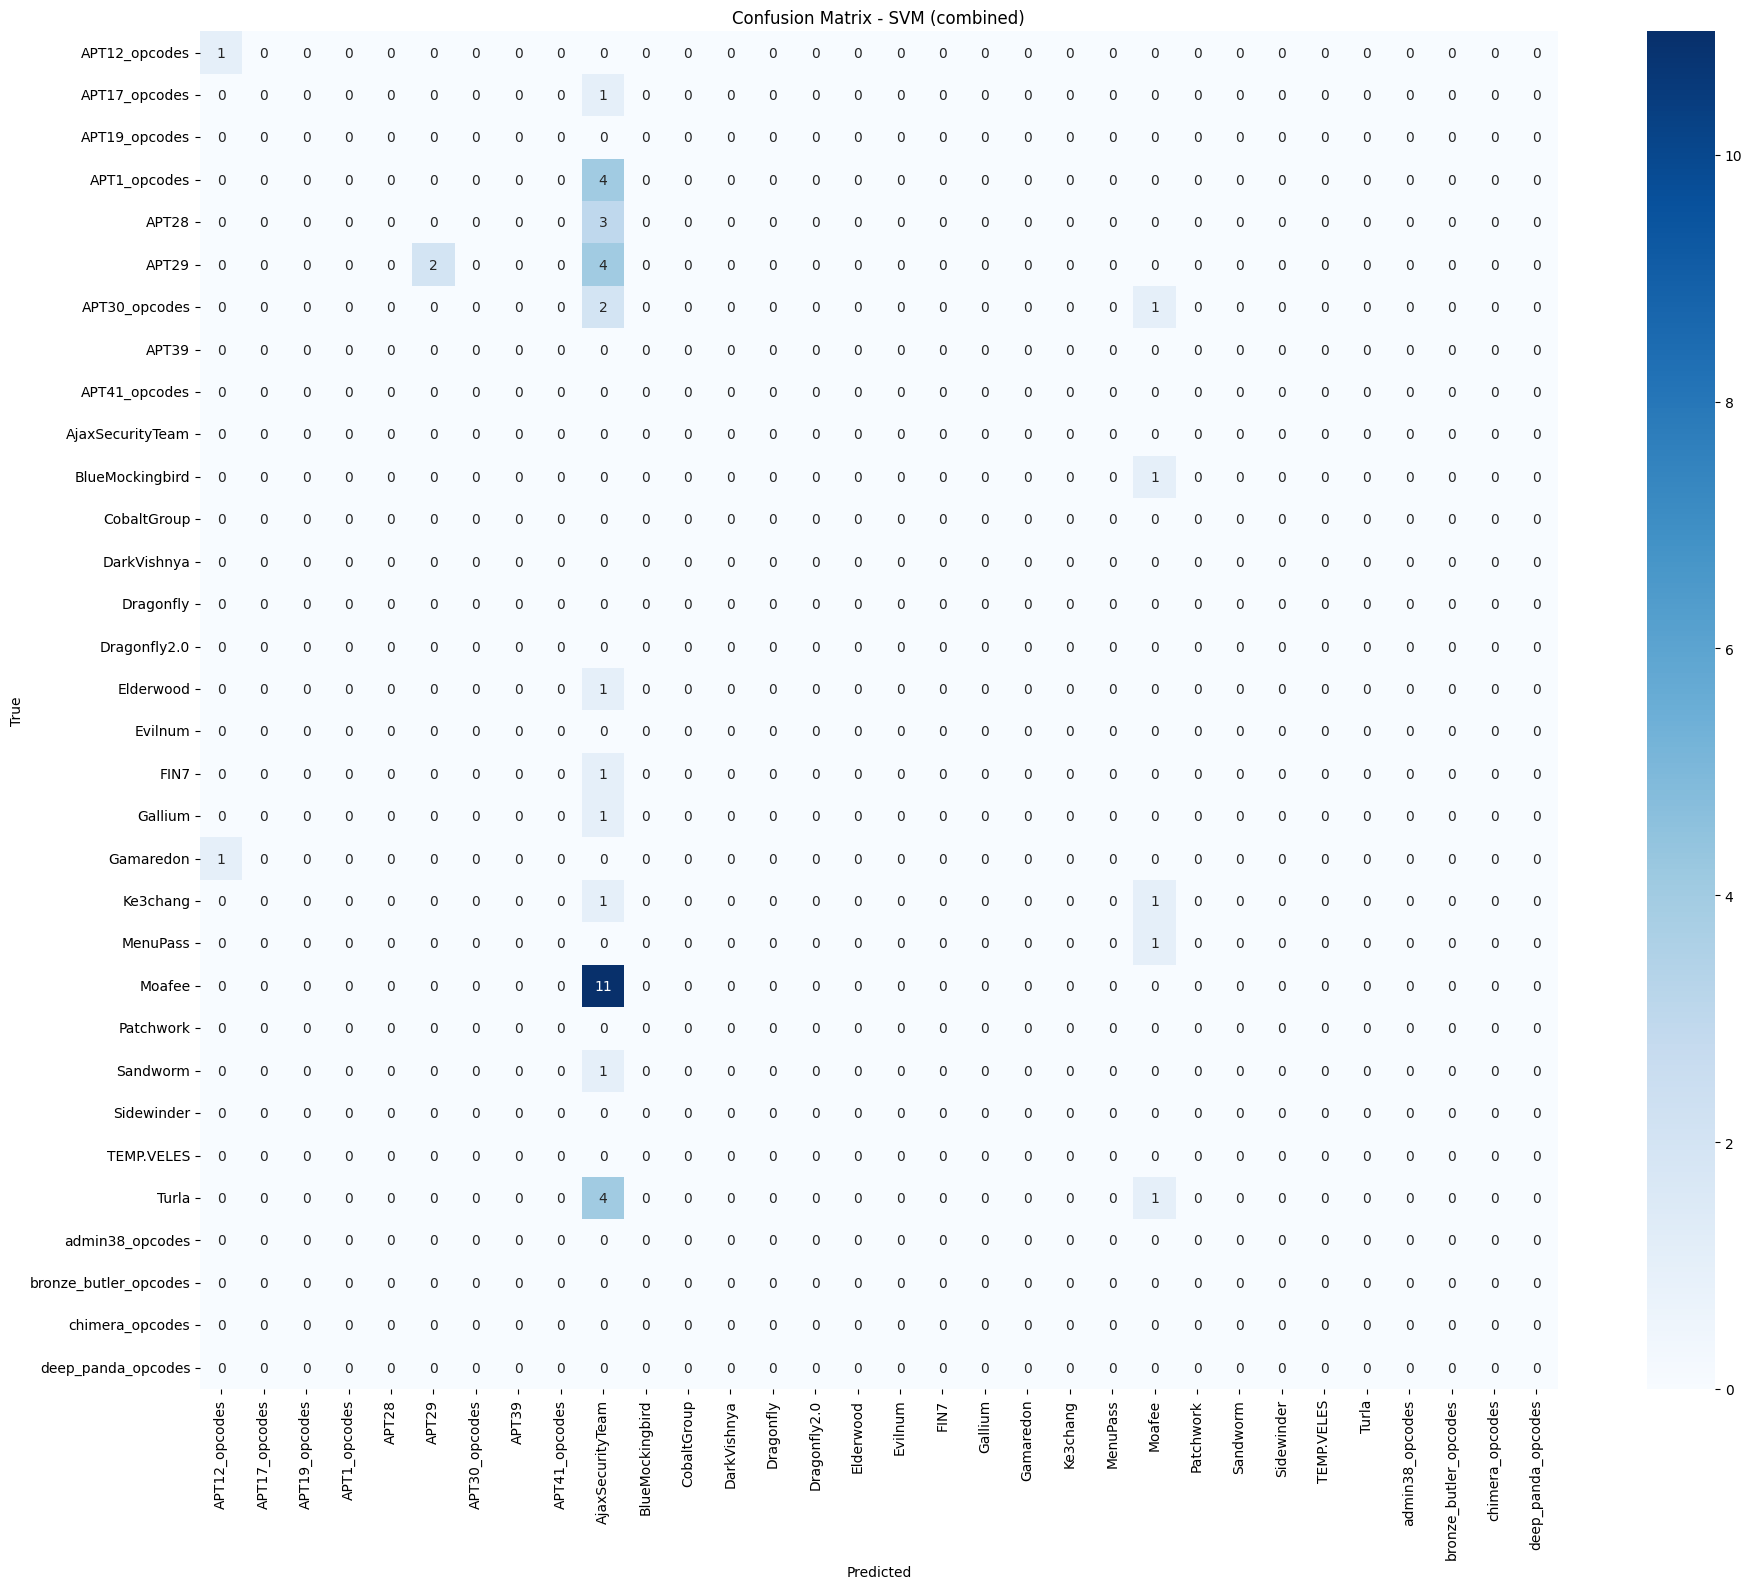


Per-class Metrics:
--------------------------------------------------------------------------------
Class                           Precision     Recall   F1-score    Support
--------------------------------------------------------------------------------
APT12_opcodes                      0.5000     1.0000     0.6667          1
APT17_opcodes                      0.0000     0.0000     0.0000          1
APT19_opcodes                      0.0000     0.0000     0.0000          0
APT1_opcodes                       0.0000     0.0000     0.0000          4
APT28                              0.0000     0.0000     0.0000          3
APT29                              1.0000     0.3333     0.5000          6
APT30_opcodes                      0.0000     0.0000     0.0000          3
APT39                              0.0000     0.0000     0.0000          0
APT41_opcodes                      0.0000     0.0000     0.0000          0
AjaxSecurityTeam                   0.0000     0.0000     0.0000     

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

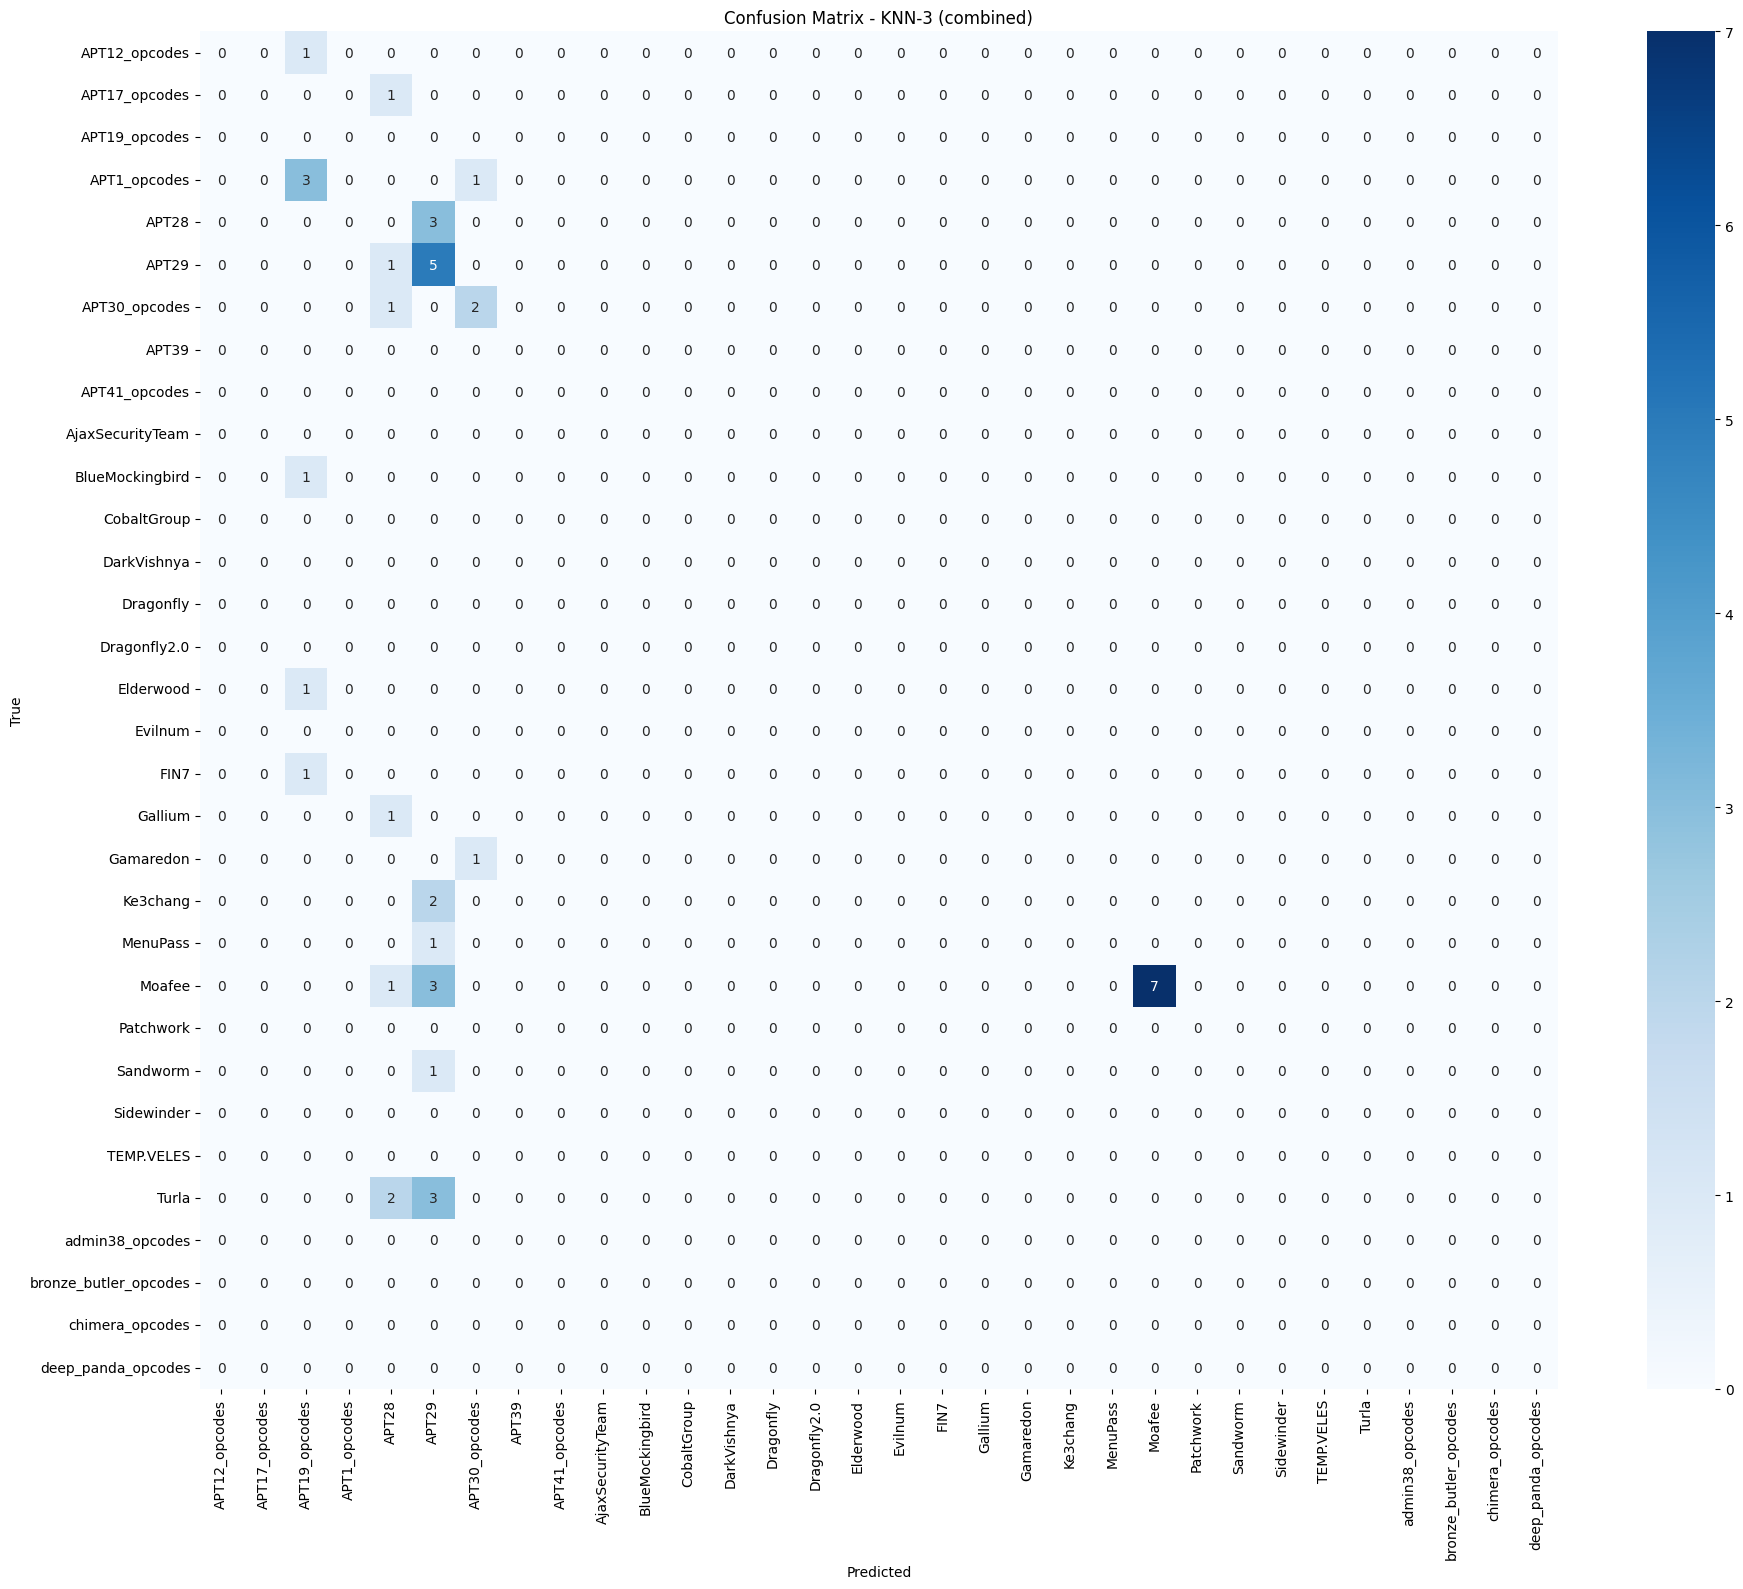


Per-class Metrics:
--------------------------------------------------------------------------------
Class                           Precision     Recall   F1-score    Support
--------------------------------------------------------------------------------
APT12_opcodes                      0.0000     0.0000     0.0000          1
APT17_opcodes                      0.0000     0.0000     0.0000          1
APT19_opcodes                      0.0000     0.0000     0.0000          0
APT1_opcodes                       0.0000     0.0000     0.0000          4
APT28                              0.0000     0.0000     0.0000          3
APT29                              0.2778     0.8333     0.4167          6
APT30_opcodes                      0.5000     0.6667     0.5714          3
APT39                              0.0000     0.0000     0.0000          0
APT41_opcodes                      0.0000     0.0000     0.0000          0
AjaxSecurityTeam                   0.0000     0.0000     0.0000     

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

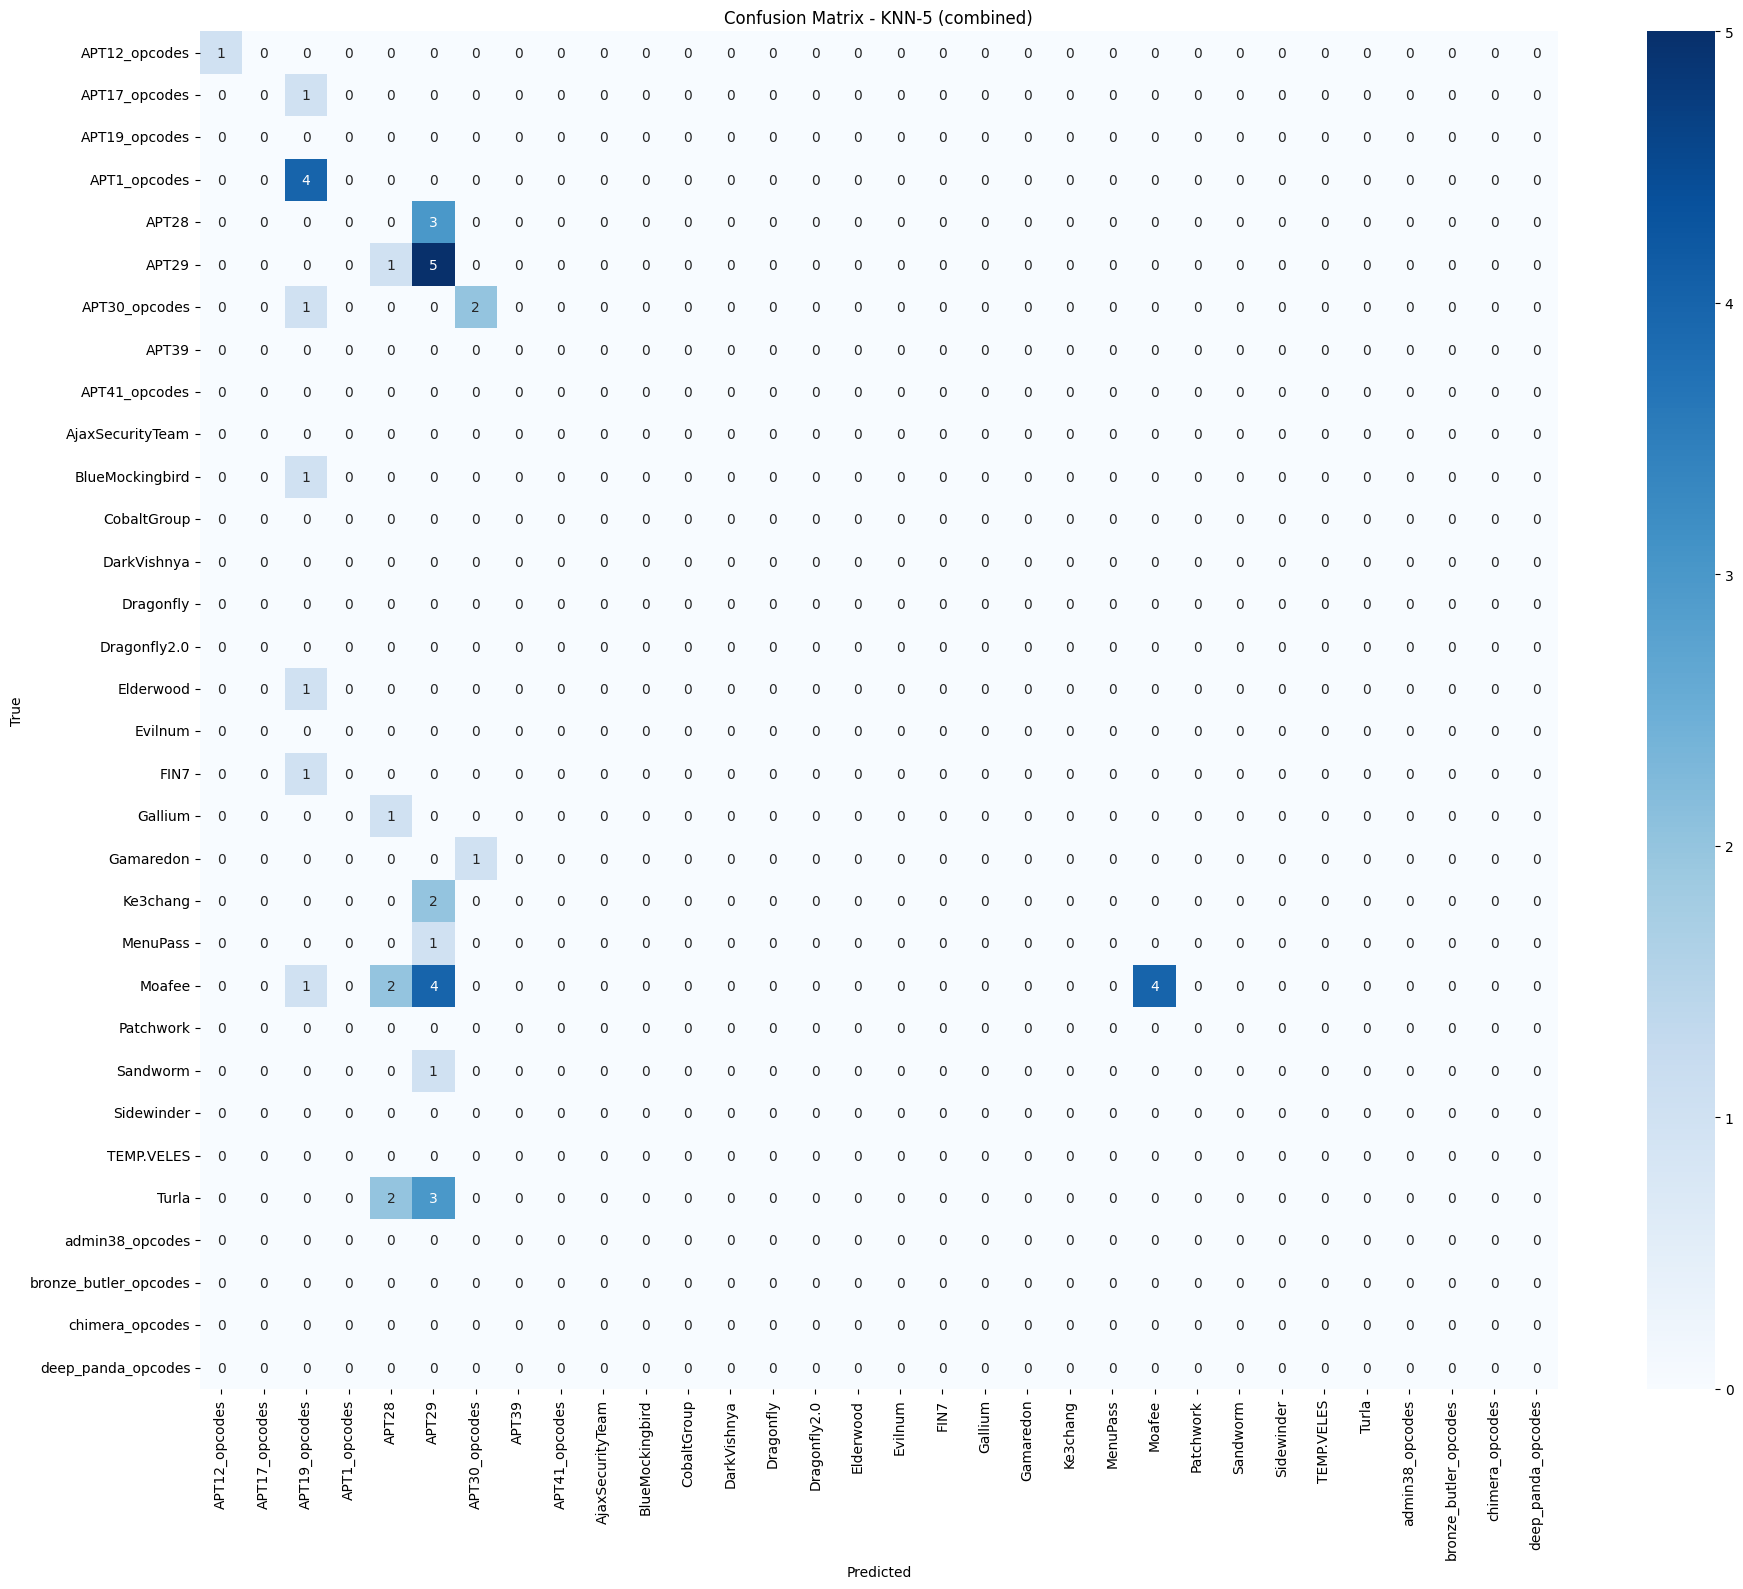


Per-class Metrics:
--------------------------------------------------------------------------------
Class                           Precision     Recall   F1-score    Support
--------------------------------------------------------------------------------
APT12_opcodes                      1.0000     1.0000     1.0000          1
APT17_opcodes                      0.0000     0.0000     0.0000          1
APT19_opcodes                      0.0000     0.0000     0.0000          0
APT1_opcodes                       0.0000     0.0000     0.0000          4
APT28                              0.0000     0.0000     0.0000          3
APT29                              0.2632     0.8333     0.4000          6
APT30_opcodes                      0.6667     0.6667     0.6667          3
APT39                              0.0000     0.0000     0.0000          0
APT41_opcodes                      0.0000     0.0000     0.0000          0
AjaxSecurityTeam                   0.0000     0.0000     0.0000     

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

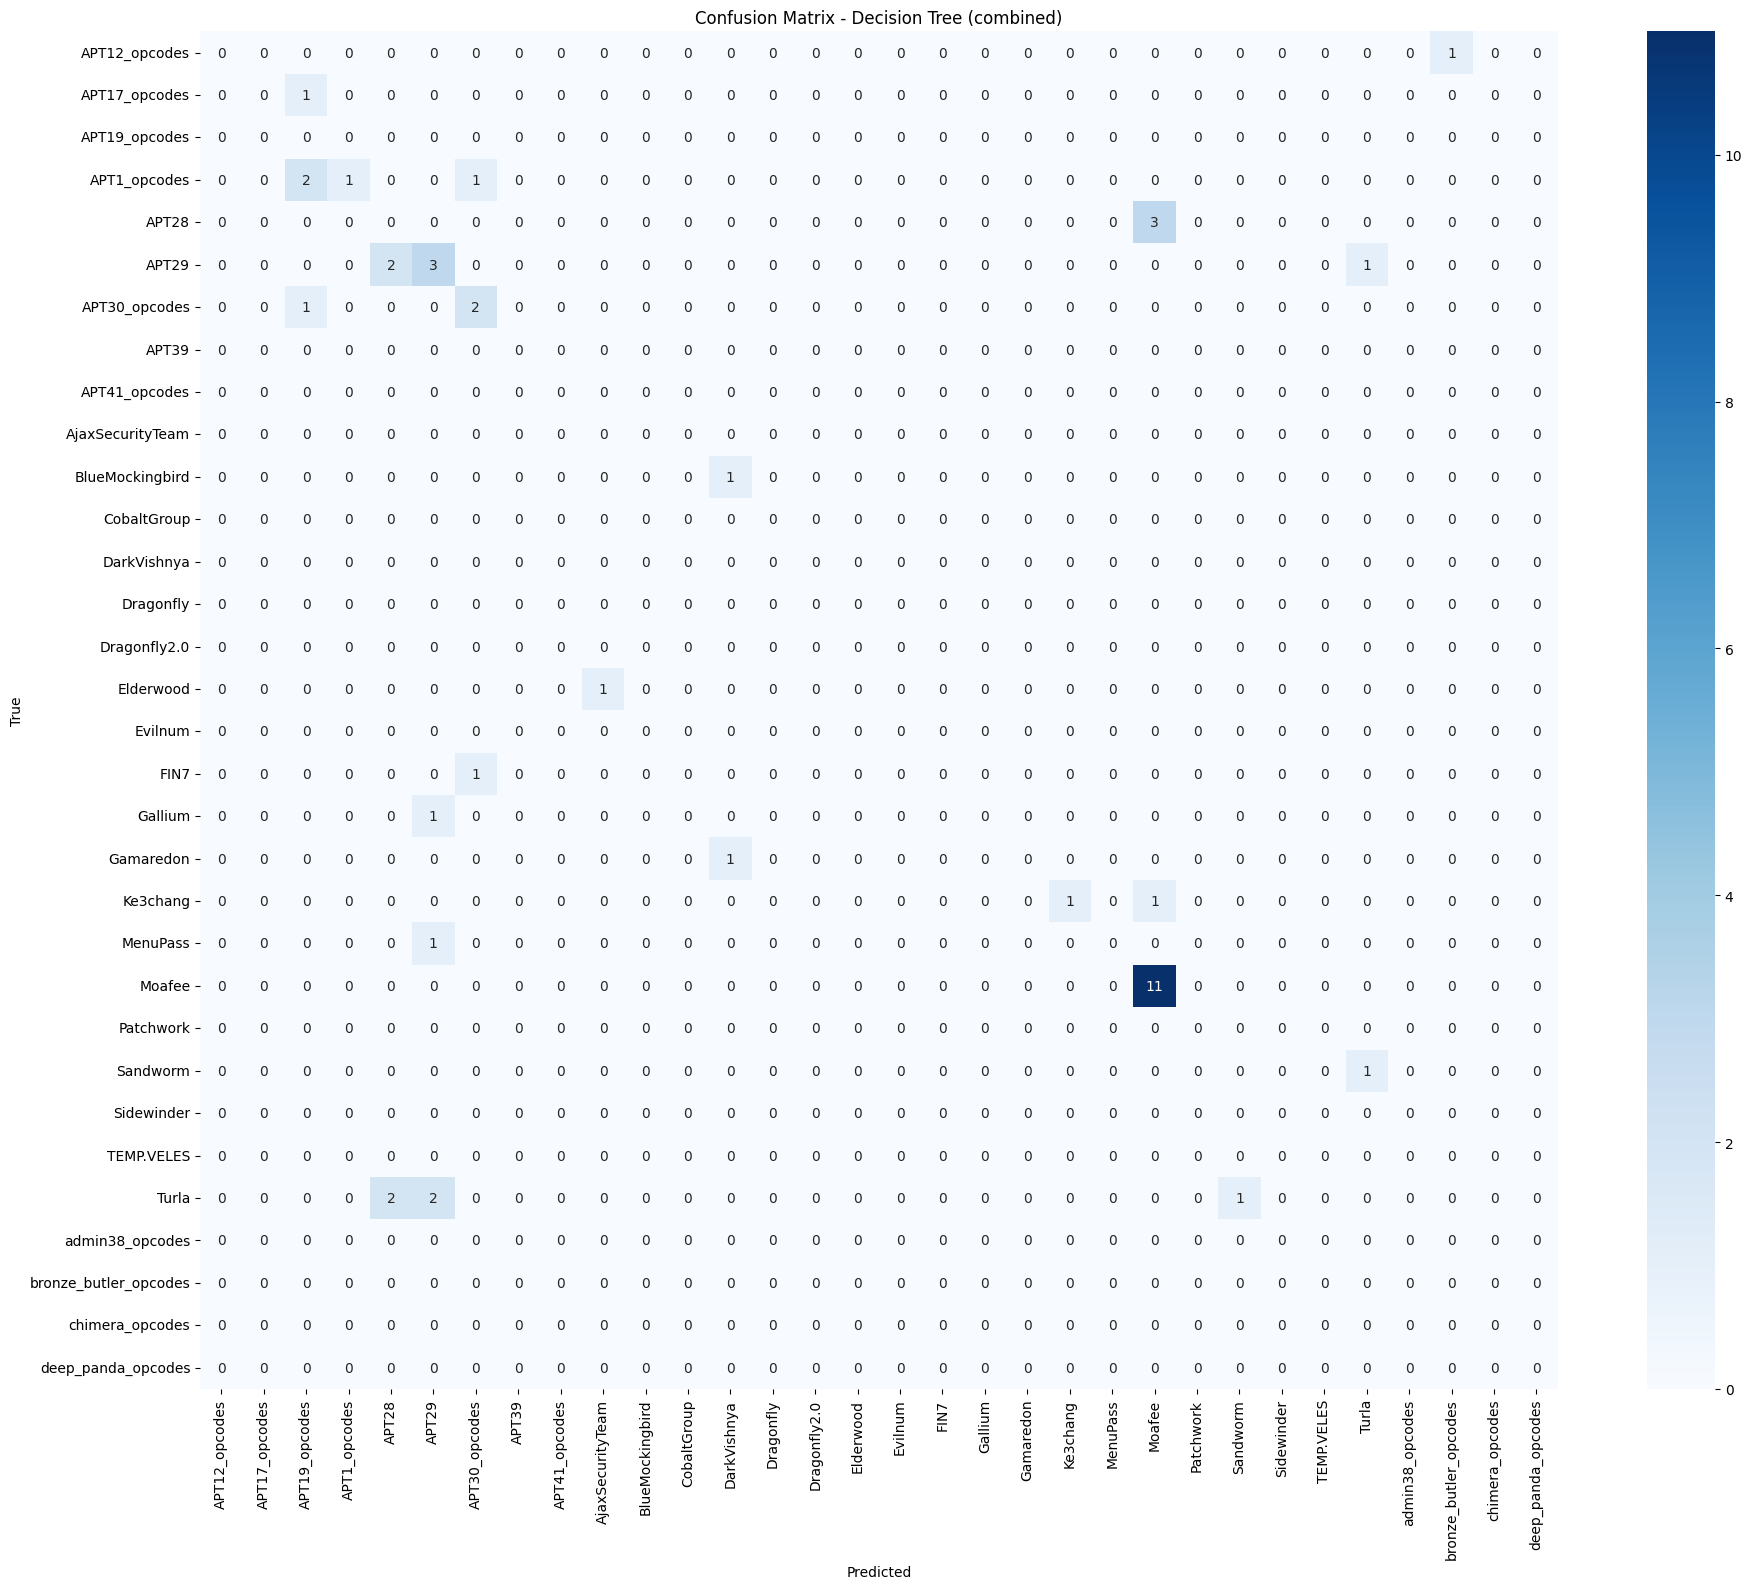


Per-class Metrics:
--------------------------------------------------------------------------------
Class                           Precision     Recall   F1-score    Support
--------------------------------------------------------------------------------
APT12_opcodes                      0.0000     0.0000     0.0000          1
APT17_opcodes                      0.0000     0.0000     0.0000          1
APT19_opcodes                      0.0000     0.0000     0.0000          0
APT1_opcodes                       1.0000     0.2500     0.4000          4
APT28                              0.0000     0.0000     0.0000          3
APT29                              0.4286     0.5000     0.4615          6
APT30_opcodes                      0.5000     0.6667     0.5714          3
APT39                              0.0000     0.0000     0.0000          0
APT41_opcodes                      0.0000     0.0000     0.0000          0
AjaxSecurityTeam                   0.0000     0.0000     0.0000     

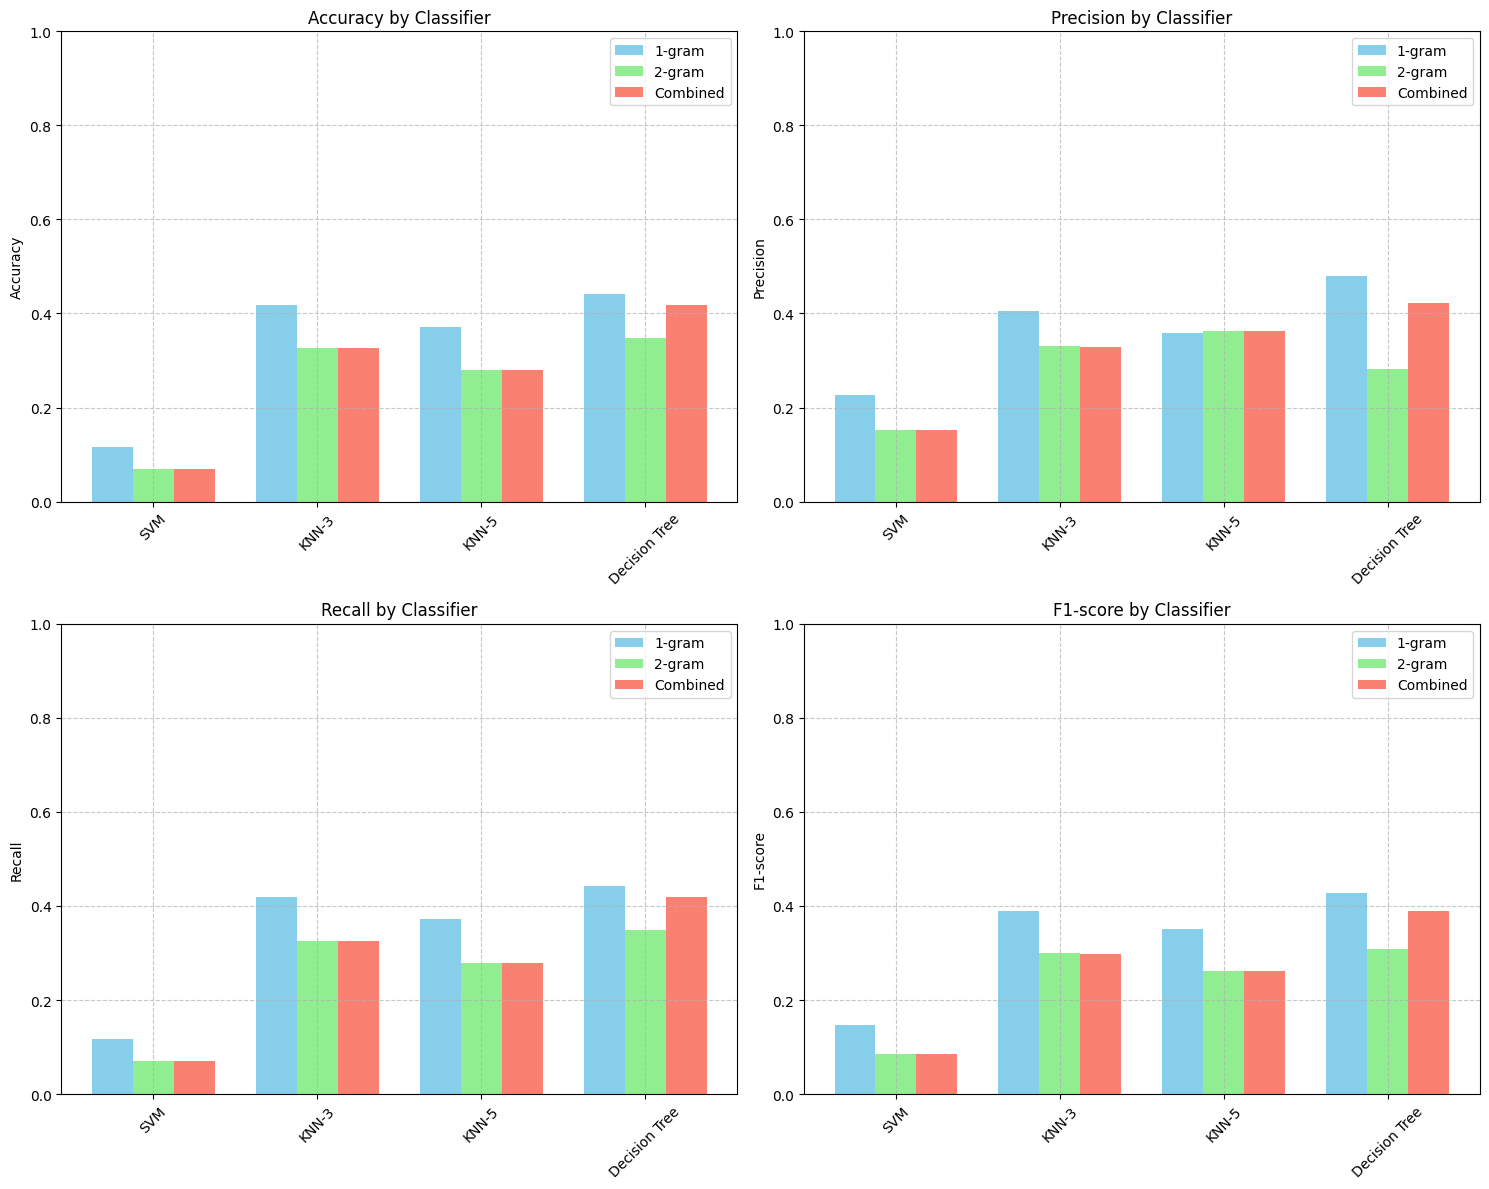

In [13]:
def evaluate_classifier(clf, X_train, X_test, y_train, y_test, feature_type, clf_name):
    # Train and predict
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    # Store results in appropriate dictionary
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_true': y_test,
        'y_pred': y_pred
    }
    
    if feature_type == '1gram':
        results_1gram[clf_name] = results
    elif feature_type == '2gram':
        results_2gram[clf_name] = results
    else:
        results_combined[clf_name] = results
    
    # Print classification report
    print(f"{clf_name} Results:")
    print(f"Accuracy: {accuracy:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(20, 16))
    
    # Create confusion matrix with all possible classes
    all_classes = np.arange(len(le.classes_))
    cm = confusion_matrix(y_test, y_pred, labels=all_classes)
    
    # Create heatmap with only counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, 
                yticklabels=le.classes_,
                square=True)
    
    plt.title(f'Confusion Matrix - {clf_name} ({feature_type})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print per-class metrics
    print("\nPer-class Metrics:")
    print("-" * 80)
    
    # Calculate metrics for all classes
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred,
        labels=all_classes,
        zero_division=0
    )
    
    print(f"{'Class':<30} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'Support':>10}")
    print("-" * 80)
    
    for i, class_name in enumerate(le.classes_):
        print(f"{class_name:<30} {precision[i]:>10.4f} {recall[i]:>10.4f} "
              f"{f1[i]:>10.4f} {support[i]:>10d}")
    print("-" * 80 + "\n")

    return results
        
# Initialize results dictionaries
results_1gram = {}
results_2gram = {}
results_combined = {}

# Scale the features
scaler = StandardScaler()
X_1gram_scaled = scaler.fit_transform(X_1gram)
X_2gram_scaled = scaler.fit_transform(X_2gram)
X_combined_scaled = np.concatenate([X_1gram_scaled, X_2gram_scaled], axis=1)

# Create features dictionary
features = {
    '1gram': (X_1gram_scaled, y),
    '2gram': (X_2gram_scaled, y),
    'combined': (X_combined_scaled, y)
}

# Initialize classifiers
classifiers = {
    'SVM': SVC(kernel='rbf', class_weight='balanced'),
    'KNN-3': KNeighborsClassifier(n_neighbors=3),
    'KNN-5': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced')
}

# Evaluate classifiers
for feature_type, (X, y) in features.items():
    print(f"\nEvaluating {feature_type} features:")
    print("=" * 80)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for clf_name, clf in classifiers.items():
        evaluate_classifier(clf, X_train, X_test, y_train, y_test, feature_type, clf_name)

# Plot comparison
def plot_metrics_comparison():
    classifiers_list = list(classifiers.keys())
    metrics = {
        '1-gram': {
            'Accuracy': [results_1gram[clf]['accuracy'] for clf in classifiers_list],
            'Precision': [results_1gram[clf]['precision'] for clf in classifiers_list],
            'Recall': [results_1gram[clf]['recall'] for clf in classifiers_list],
            'F1-score': [results_1gram[clf]['f1'] for clf in classifiers_list]
        },
        '2-gram': {
            'Accuracy': [results_2gram[clf]['accuracy'] for clf in classifiers_list],
            'Precision': [results_2gram[clf]['precision'] for clf in classifiers_list],
            'Recall': [results_2gram[clf]['recall'] for clf in classifiers_list],
            'F1-score': [results_2gram[clf]['f1'] for clf in classifiers_list]
        },
        'Combined': {
            'Accuracy': [results_combined[clf]['accuracy'] for clf in classifiers_list],
            'Precision': [results_combined[clf]['precision'] for clf in classifiers_list],
            'Recall': [results_combined[clf]['recall'] for clf in classifiers_list],
            'F1-score': [results_combined[clf]['f1'] for clf in classifiers_list]
        }
    }

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    
    for idx, metric in enumerate(metrics_list):
        ax = axes[idx//2, idx%2]
        x = np.arange(len(classifiers_list))
        width = 0.25
        
        ax.bar(x - width, metrics['1-gram'][metric], width, label='1-gram', color='skyblue')
        ax.bar(x, metrics['2-gram'][metric], width, label='2-gram', color='lightgreen')
        ax.bar(x + width, metrics['Combined'][metric], width, label='Combined', color='salmon')
        
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} by Classifier')
        ax.set_xticks(x)
        ax.set_xticklabels(classifiers_list, rotation=45)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_ylim(0, 1.0)

    plt.tight_layout()
    plt.show()

# Generate final comparison plot
plot_metrics_comparison()
        

## Balancing Training Data Across APT Groups and Re-Evaluating Classifiers

### Key Functions and Processes:

1. **`balance_and_evaluate`**:
   - Balances the dataset using a hybrid approach:
     - **RandomOverSampler (ROS)**: Handles classes with very few samples.
     - **SMOTE**: Generates synthetic samples for minority classes.
   - Splits the balanced dataset into training and testing sets.
   - Trains classifiers on the balanced dataset and evaluates their performance.
   - Metrics:
     - Accuracy, Precision, Recall, F1-score (weighted average).
     - Classification report for detailed per-class metrics.

2. **Feature Scaling**:
   - Scales 1-gram and 2-gram features using `StandardScaler`.
   - Combines scaled features into a single matrix for evaluation.

3. **Classifier Initialization**:
   - Includes models with class balancing settings:
     - SVM (class weight balanced, probabilistic outputs).
     - KNN with k=3 and k=5 (distance-weighted).
     - Decision Tree (balanced class weights, depth and split constraints).

4. **Evaluation Pipeline**:
   - Evaluates each classifier for:
     - 1-gram features.
     - 2-gram features.
     - Combined features (1-gram + 2-gram).
   - Prints classification reports and accuracy scores for each classifier.

5. **Accuracy Summary**:
   - Compares accuracy across classifiers and feature types in a tabular format.

### Outputs:
- Balanced class distributions before and after applying ROS + SMOTE.
- Detailed metrics (accuracy, precision, recall, F1-score) for each feature type and classifier.
- Accuracy comparison summary for all classifiers.


In [15]:
def balance_and_evaluate(X, y, classifiers, le):
    # Print original class distribution
    original_dist = Counter(le.inverse_transform(y))
    print("Original class distribution:")
    print(original_dist)
    
    # First use RandomOverSampler to handle classes with single samples
    ros = RandomOverSampler(random_state=42)
    X_ros, y_ros = ros.fit_resample(X, y)
    
    # Then apply SMOTE
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X_ros, y_ros)
    
    print("\nBalanced class distribution:")
    print(Counter(le.inverse_transform(y_balanced)))
    
    # Split the balanced dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )
    
    # Dictionary to store results
    results = {}
    
    # Evaluate each classifier
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, 
                                    target_names=le.classes_,
                                    zero_division=0)
        
        # Store additional metrics
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        
        results[name] = {
            'accuracy': accuracy,
            'report': report,
            'y_true': y_test,
            'y_pred': y_pred,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        
        print(f"\n{name} Results (with balanced data):")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(report)
        print("-" * 80)
    
    return results
# Initialize classifiers with balanced settings
classifiers = {
    'SVM': SVC(kernel='rbf', class_weight='balanced', probability=True),
    'KNN-3': KNeighborsClassifier(n_neighbors=3, weights='distance'),
    'KNN-5': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', 
                                          max_depth=10,
                                          min_samples_split=5)
}

# Scale features
scaler = StandardScaler()
X_1gram_scaled = scaler.fit_transform(X_1gram)
X_2gram_scaled = scaler.fit_transform(X_2gram)

# Create combined features by concatenating scaled 1-gram and 2-gram features
X_combined_scaled = np.concatenate([X_1gram_scaled, X_2gram_scaled], axis=1)

# Evaluate with balanced classes
print("\nEvaluating 1-gram features:")
results_1gram = balance_and_evaluate(X_1gram_scaled, y, classifiers, le)

print("\nEvaluating 2-gram features:")
results_2gram = balance_and_evaluate(X_2gram_scaled, y, classifiers, le)

print("\nEvaluating combined features:")
results_combined = balance_and_evaluate(X_combined_scaled, y, classifiers, le)

# Print comparison summary
print("\nAccuracy Comparison Summary (with balanced data):")
print("-" * 80)
print(f"{'Classifier':<15} {'1-gram':>10} {'2-gram':>10} {'Combined':>10}")
print("-" * 80)
for clf_name, _ in classifiers.items():
    print(f"{clf_name:<15} {results_1gram[clf_name]['accuracy']:>10.4f} "
          f"{results_2gram[clf_name]['accuracy']:>10.4f} "
          f"{results_combined[clf_name]['accuracy']:>10.4f}")


Evaluating 1-gram features:
Original class distribution:
Counter({'Moafee': 45, 'APT29': 40, 'Turla': 24, 'APT28': 21, 'APT1_opcodes': 15, 'APT30_opcodes': 15, 'APT19_opcodes': 8, 'Sandworm': 7, 'Ke3chang': 5, 'APT12_opcodes': 5, 'Gallium': 5, 'admin38_opcodes': 2, 'FIN7': 2, 'CobaltGroup': 2, 'MenuPass': 2, 'Evilnum': 1, 'BlueMockingbird': 1, 'Dragonfly': 1, 'Dragonfly2.0': 1, 'DarkVishnya': 1, 'bronze_butler_opcodes': 1, 'Patchwork': 1, 'deep_panda_opcodes': 1, 'AjaxSecurityTeam': 1, 'Elderwood': 1, 'Sidewinder': 1, 'APT17_opcodes': 1, 'Gamaredon': 1, 'chimera_opcodes': 1, 'APT39': 1, 'APT41_opcodes': 1, 'TEMP.VELES': 1})

Balanced class distribution:
Counter({'Evilnum': 45, 'APT19_opcodes': 45, 'BlueMockingbird': 45, 'Dragonfly': 45, 'Dragonfly2.0': 45, 'APT29': 45, 'DarkVishnya': 45, 'Sandworm': 45, 'Turla': 45, 'APT28': 45, 'admin38_opcodes': 45, 'FIN7': 45, 'bronze_butler_opcodes': 45, 'Ke3chang': 45, 'APT1_opcodes': 45, 'Patchwork': 45, 'deep_panda_opcodes': 45, 'APT12_opcodes'

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_


SVM Results (with balanced data):
Accuracy: 0.7222

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       0.90      1.00      0.95         9
        APT17_opcodes       0.75      1.00      0.86         9
        APT19_opcodes       1.00      0.11      0.20         9
         APT1_opcodes       1.00      0.33      0.50         9
                APT28       0.40      0.22      0.29         9
                APT29       0.50      0.56      0.53         9
        APT30_opcodes       0.00      0.00      0.00         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       0.69      1.00      0.82         9
     AjaxSecurityTeam       0.50      1.00      0.67         9
      BlueMockingbird       1.00      1.00      1.00         9
          CobaltGroup       1.00      1.00      1.00         9
          DarkVishnya       1.00      1.00      1.00         9
            Dragonfly       0.00      0.0

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_


SVM Results (with balanced data):
Accuracy: 0.7361

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00         9
        APT17_opcodes       1.00      1.00      1.00         9
        APT19_opcodes       1.00      0.56      0.71         9
         APT1_opcodes       1.00      0.11      0.20         9
                APT28       1.00      0.22      0.36         9
                APT29       1.00      0.11      0.20         9
        APT30_opcodes       1.00      0.22      0.36         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       1.00      1.00      1.00         9
     AjaxSecurityTeam       0.18      1.00      0.30         9
      BlueMockingbird       1.00      1.00      1.00         9
          CobaltGroup       1.00      1.00      1.00         9
          DarkVishnya       1.00      1.00      1.00         9
            Dragonfly       0.00      0.0

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Decision Tree Results (with balanced data):
Accuracy: 0.3438

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       0.05      1.00      0.09         9
        APT17_opcodes       0.00      0.00      0.00         9
        APT19_opcodes       0.00      0.00      0.00         9
         APT1_opcodes       0.00      0.00      0.00         9
                APT28       0.00      0.00      0.00         9
                APT29       0.00      0.00      0.00         9
        APT30_opcodes       0.00      0.00      0.00         9
                APT39       0.00      0.00      0.00         9
        APT41_opcodes       0.00      0.00      0.00         9
     AjaxSecurityTeam       0.00      0.00      0.00         9
      BlueMockingbird       1.00      1.00      1.00         9
          CobaltGroup       0.00      0.00      0.00         9
          DarkVishnya       1.00      1.00      1.00         9
            Dragonfly       0.5

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_


SVM Results (with balanced data):
Accuracy: 0.7361

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00         9
        APT17_opcodes       1.00      1.00      1.00         9
        APT19_opcodes       1.00      0.56      0.71         9
         APT1_opcodes       1.00      0.11      0.20         9
                APT28       1.00      0.22      0.36         9
                APT29       1.00      0.11      0.20         9
        APT30_opcodes       1.00      0.22      0.36         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       1.00      1.00      1.00         9
     AjaxSecurityTeam       0.18      1.00      0.31         9
      BlueMockingbird       1.00      1.00      1.00         9
          CobaltGroup       1.00      1.00      1.00         9
          DarkVishnya       1.00      1.00      1.00         9
            Dragonfly       0.00      0.0

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Bar Chart Visualization of Classification Accuracy for Balanced Data

### Key Processes:

1. **Data Definition**:
   - Specifies classifiers (`SVM`, `KNN-3`, `KNN-5`, `Decision Tree`) and their accuracies for:
     - 1-gram features.
     - 2-gram features.
     - Combined features.

2. **Bar Chart Creation**:
   - Constructs a grouped bar chart to compare classifier accuracies across feature types.
   - Positions bars:
     - `x - width`: 1-gram features.
     - `x`: 2-gram features.
     - `x + width`: Combined features.

3. **Plot Customization**:
   - Labels:
     - Y-axis as "Accuracy."
     - Title: "Classification Accuracy by Feature Type and Classifier (After Balancing)."
   - Adds a legend to differentiate feature types.
   - Applies a dashed grid for readability.

4. **Value Annotations**:
   - Annotates each bar with its corresponding accuracy value using the `autolabel` function.

5. **Display Settings**:
   - Sets y-axis limits between 0 and 1.
   - Adjusts layout to prevent overlap or cutoff.
   - Displays the final chart.

### Outputs:
- A visually informative grouped bar chart comparing the performance of classifiers across 1-gram, 2-gram, and combined feature sets.
- Clear annotations showing exact accuracy values on top of each bar.


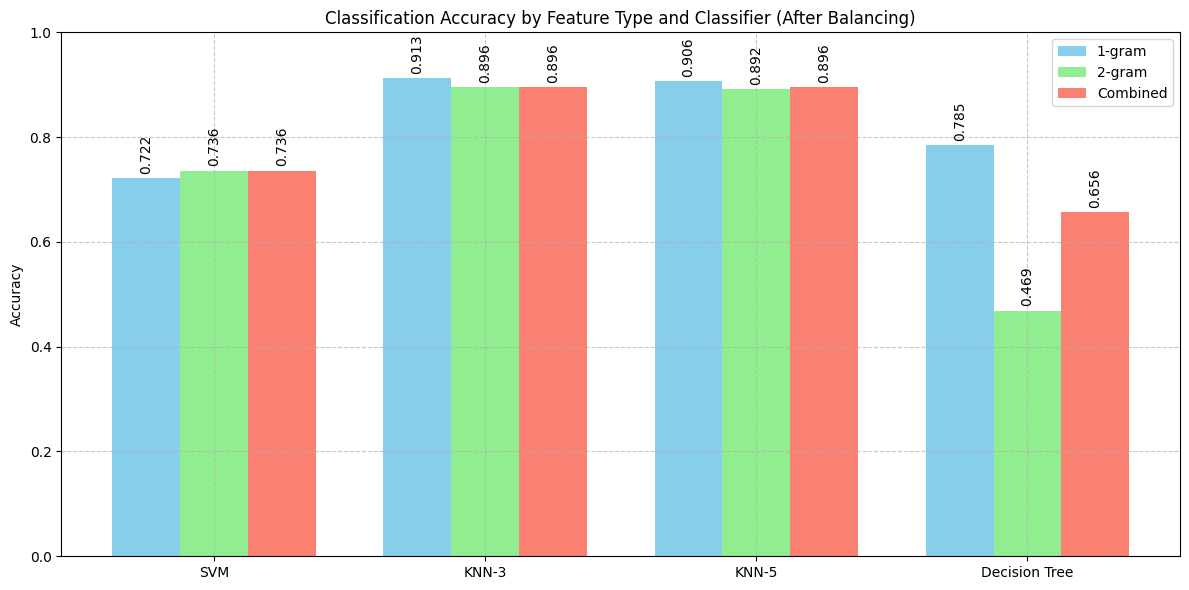

In [10]:
# Data
classifiers = ['SVM', 'KNN-3', 'KNN-5', 'Decision Tree']
accuracies_1gram = [0.7222, 0.9132, 0.9062, 0.7847]
accuracies_2gram = [0.7361, 0.8958, 0.8924, 0.4688]
accuracies_combined = [0.7361, 0.8958, 0.8958, 0.6562]

# Set up bar width and positions
x = np.arange(len(classifiers))
width = 0.25

# Create bars
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, accuracies_1gram, width, label='1-gram', color='skyblue')
rects2 = ax.bar(x, accuracies_2gram, width, label='2-gram', color='lightgreen')
rects3 = ax.bar(x + width, accuracies_combined, width, label='Combined', color='salmon')

# Customize the plot
ax.set_ylabel('Accuracy')
ax.set_title('Classification Accuracy by Feature Type and Classifier (After Balancing)')
ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom', rotation=90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Set y-axis limits to start from 0 and end at 1
plt.ylim(0, 1.0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## Detailed Metrics and Comparison for Classifiers Trained on Balanced Data

### Key Processes:

1. **Print Metrics for Each Feature Type**:
   - Iterates through feature types (`1-gram`, `2-gram`, `Combined`).
   - For each feature type and classifier:
     - Prints metrics: Accuracy, Precision, Recall, F1-Score.
     - Displays a detailed classification report.

2. **Confusion Matrix Visualization**:
   - Plots confusion matrices for each classifier and feature type.
   - Annotates matrices with true and predicted labels for better interpretability.

3. **Summary Comparison Plot**:
   - Creates a grouped bar chart comparing classifier accuracies across feature types.
   - Features:
     - X-axis: Classifiers (`SVM`, `KNN-3`, `KNN-5`, `Decision Tree`).
     - Bar colors: Different feature types (1-gram, 2-gram, Combined).
     - Y-axis: Accuracy scores.
   - Adds a grid, legend, and appropriate labels for clarity.

4. **Visualization Customization**:
   - Confusion matrices and bar chart are adjusted with:
     - Rotated labels for readability.
     - Tight layout to prevent overlap.
     - Consistent color schemes for feature type differentiation.

### Outputs:
- Detailed metrics for all classifiers and feature types, including classification reports.
- Confusion matrix heatmaps for each classifier-feature combination.
- A summary bar chart comparing classifier accuracies across feature types.



======================================== 1-gram Results ========================================

SVM Metrics:
--------------------------------------------------------------------------------
Accuracy: 0.7222
Precision: 0.7558
Recall: 0.7222
F1-Score: 0.6861

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       0.90      1.00      0.95         9
        APT17_opcodes       0.75      1.00      0.86         9
        APT19_opcodes       1.00      0.11      0.20         9
         APT1_opcodes       1.00      0.33      0.50         9
                APT28       0.40      0.22      0.29         9
                APT29       0.50      0.56      0.53         9
        APT30_opcodes       0.00      0.00      0.00         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       0.69      1.00      0.82         9
     AjaxSecurityTeam       0.50      1.00      0.67         9
      BlueMockingbird 

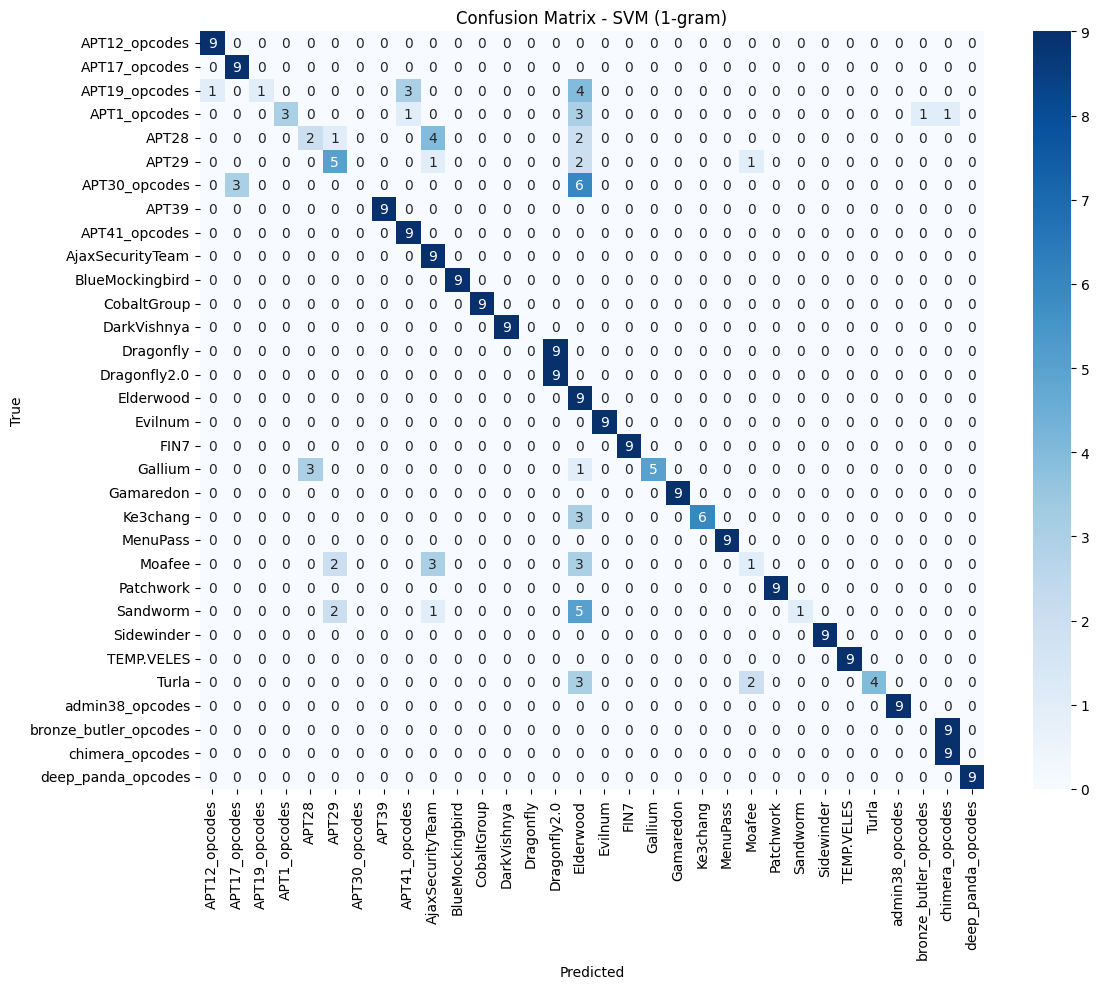

--------------------------------------------------------------------------------

KNN-3 Metrics:
--------------------------------------------------------------------------------
Accuracy: 0.9132
Precision: 0.8855
Recall: 0.9132
F1-Score: 0.8900

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00         9
        APT17_opcodes       1.00      1.00      1.00         9
        APT19_opcodes       0.90      1.00      0.95         9
         APT1_opcodes       1.00      0.89      0.94         9
                APT28       0.80      0.89      0.84         9
                APT29       1.00      1.00      1.00         9
        APT30_opcodes       1.00      1.00      1.00         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       1.00      1.00      1.00         9
     AjaxSecurityTeam       1.00      1.00      1.00         9
      BlueMockingbird       1.00     

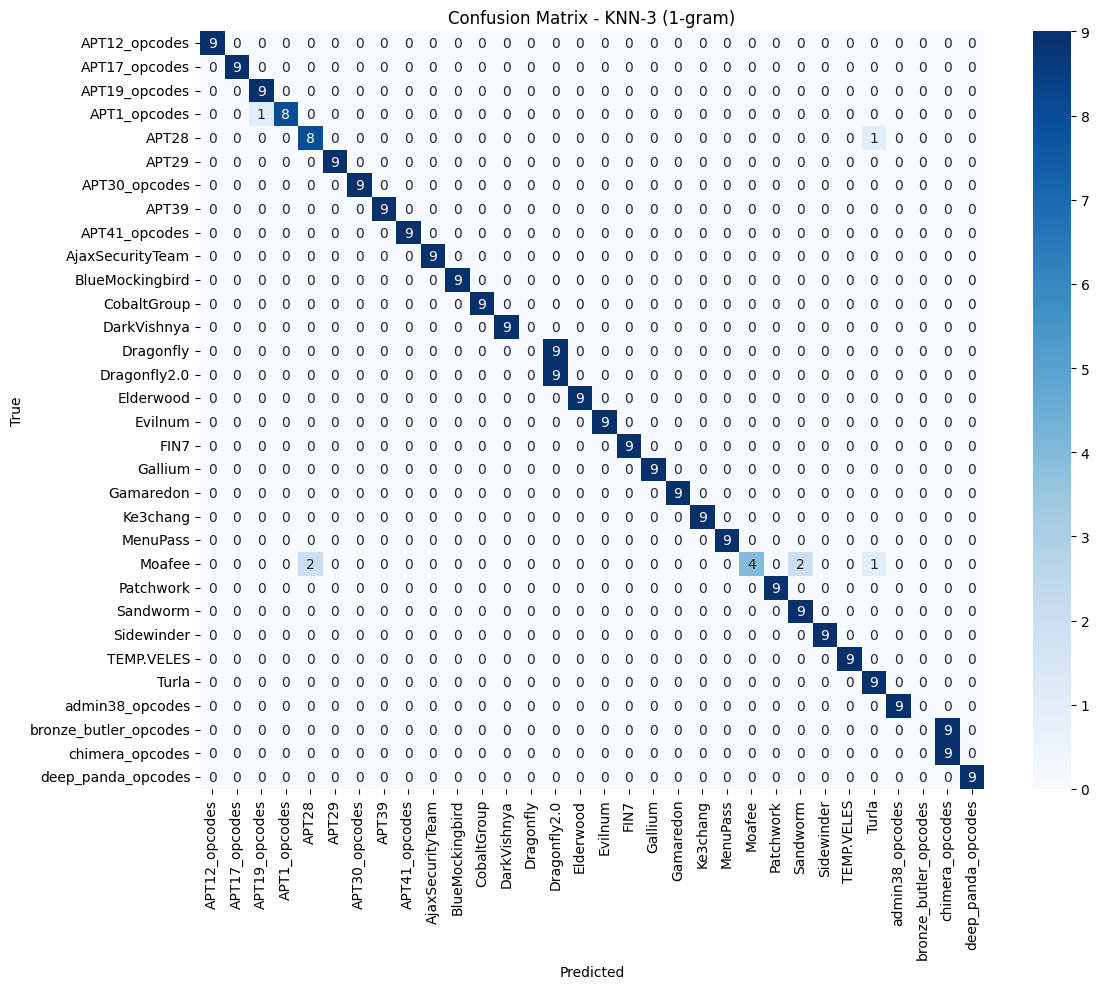

--------------------------------------------------------------------------------

KNN-5 Metrics:
--------------------------------------------------------------------------------
Accuracy: 0.9062
Precision: 0.8803
Recall: 0.9062
F1-Score: 0.8831

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00         9
        APT17_opcodes       1.00      1.00      1.00         9
        APT19_opcodes       0.90      1.00      0.95         9
         APT1_opcodes       1.00      0.89      0.94         9
                APT28       0.80      0.89      0.84         9
                APT29       1.00      0.78      0.88         9
        APT30_opcodes       1.00      1.00      1.00         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       1.00      1.00      1.00         9
     AjaxSecurityTeam       1.00      1.00      1.00         9
      BlueMockingbird       1.00     

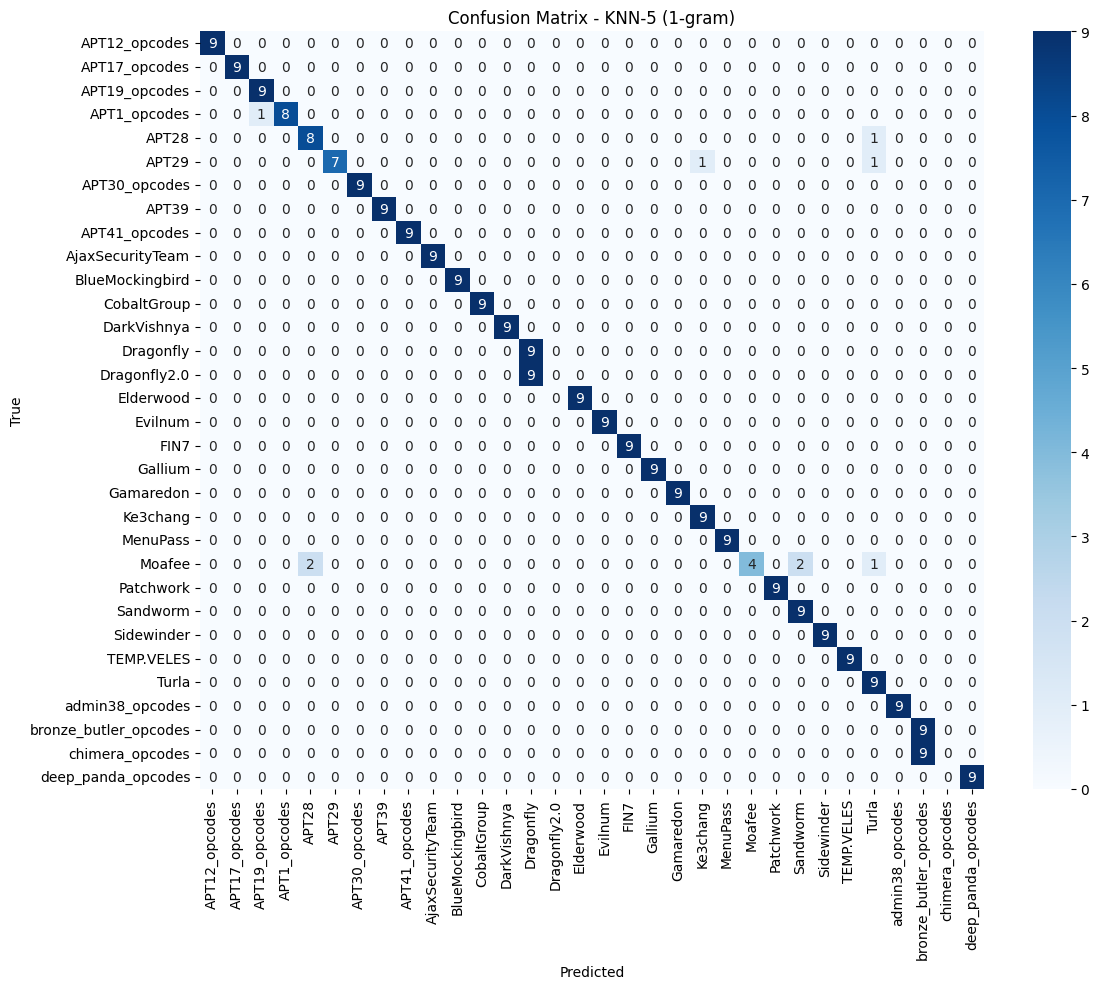

--------------------------------------------------------------------------------

Decision Tree Metrics:
--------------------------------------------------------------------------------
Accuracy: 0.4062
Precision: 0.3196
Recall: 0.4062
F1-Score: 0.3355

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       0.14      1.00      0.25         9
        APT17_opcodes       0.08      1.00      0.15         9
        APT19_opcodes       0.00      0.00      0.00         9
         APT1_opcodes       0.00      0.00      0.00         9
                APT28       0.00      0.00      0.00         9
                APT29       0.00      0.00      0.00         9
        APT30_opcodes       0.00      0.00      0.00         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       0.00      0.00      0.00         9
     AjaxSecurityTeam       0.00      0.00      0.00         9
      BlueMockingbird       1

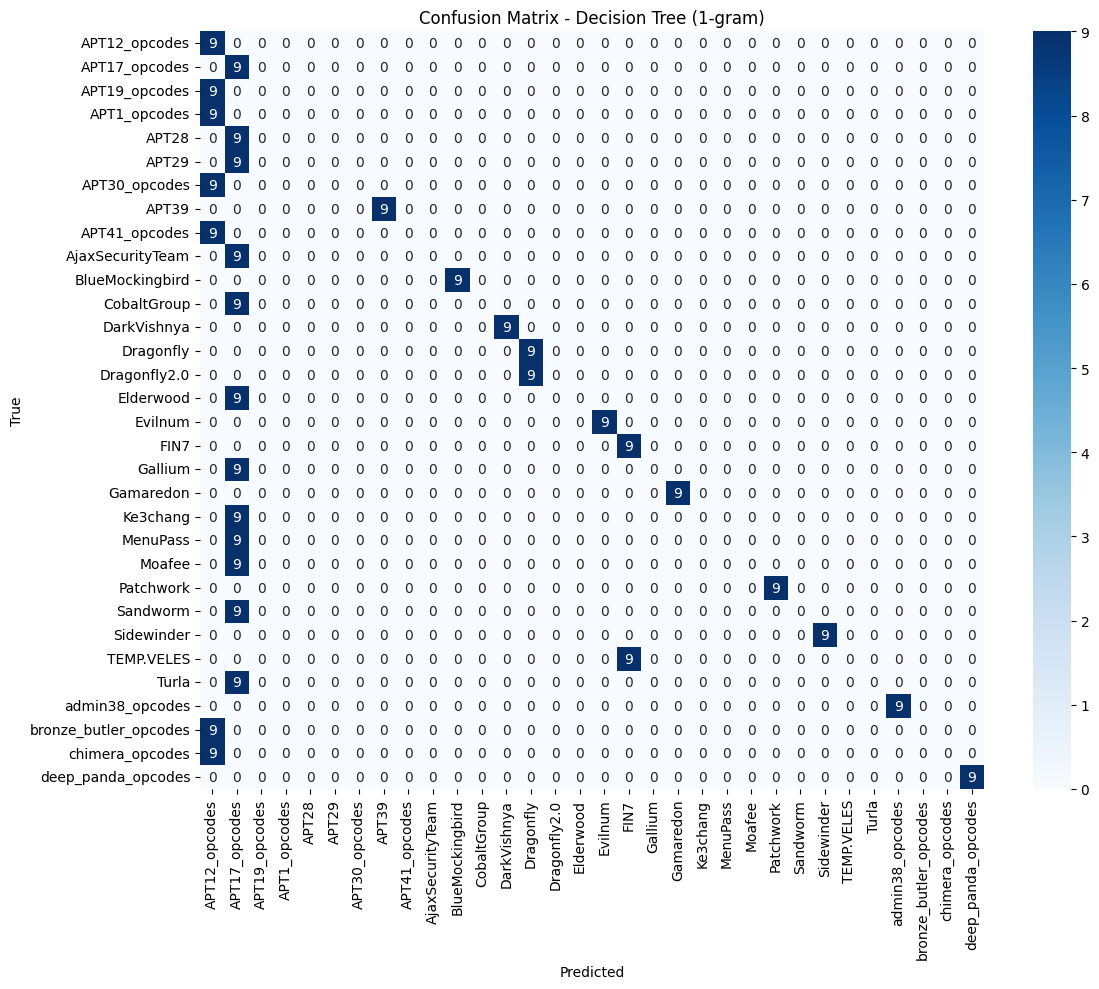

--------------------------------------------------------------------------------

======================================== 2-gram Results ========================================

SVM Metrics:
--------------------------------------------------------------------------------
Accuracy: 0.7361
Precision: 0.8618
Recall: 0.7361
F1-Score: 0.7209

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00         9
        APT17_opcodes       1.00      1.00      1.00         9
        APT19_opcodes       1.00      0.56      0.71         9
         APT1_opcodes       1.00      0.11      0.20         9
                APT28       1.00      0.22      0.36         9
                APT29       1.00      0.11      0.20         9
        APT30_opcodes       1.00      0.22      0.36         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       1.00      1.00      1.00         9
    

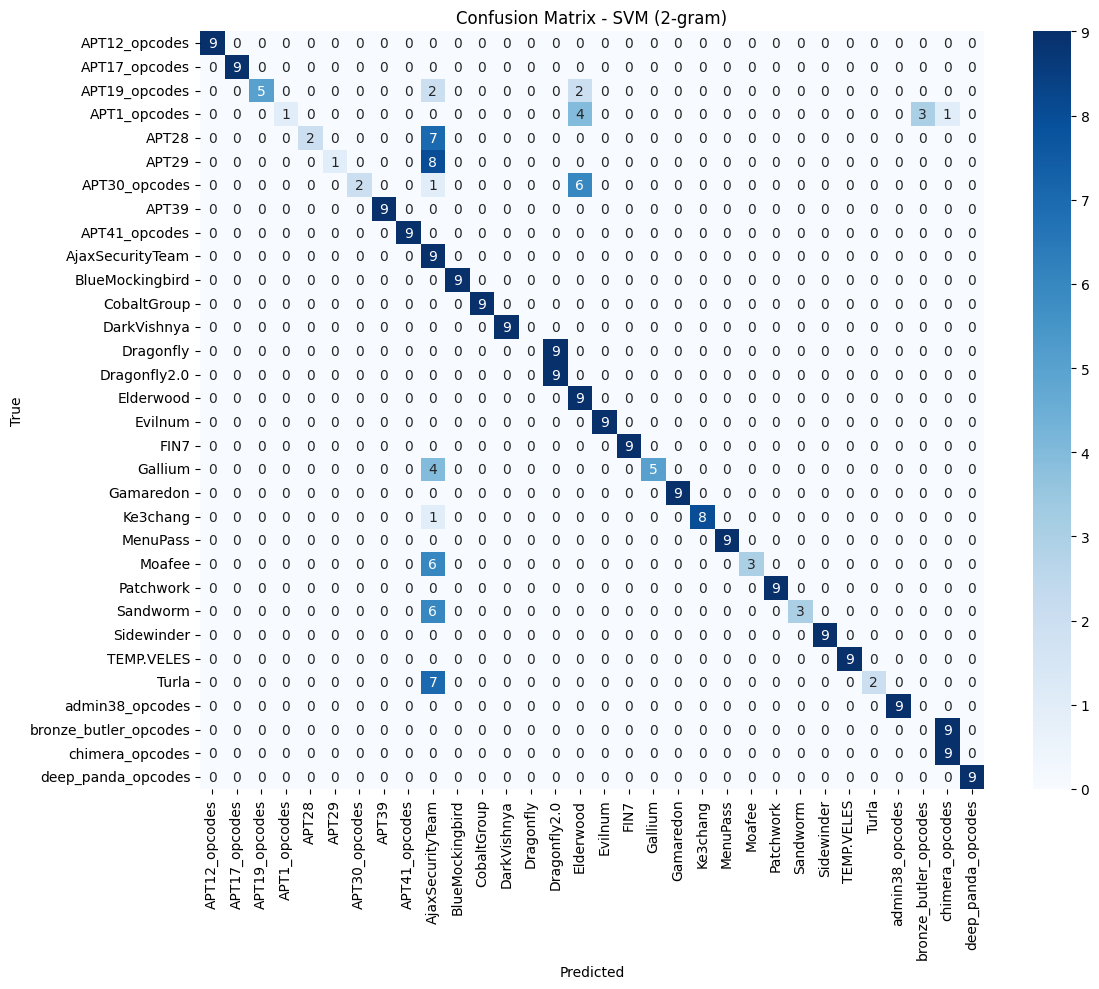

--------------------------------------------------------------------------------

KNN-3 Metrics:
--------------------------------------------------------------------------------
Accuracy: 0.8958
Precision: 0.8723
Recall: 0.8958
F1-Score: 0.8690

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00         9
        APT17_opcodes       1.00      1.00      1.00         9
        APT19_opcodes       0.90      1.00      0.95         9
         APT1_opcodes       1.00      0.78      0.88         9
                APT28       0.73      0.89      0.80         9
                APT29       0.88      0.78      0.82         9
        APT30_opcodes       0.90      1.00      0.95         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       1.00      1.00      1.00         9
     AjaxSecurityTeam       0.82      1.00      0.90         9
      BlueMockingbird       1.00     

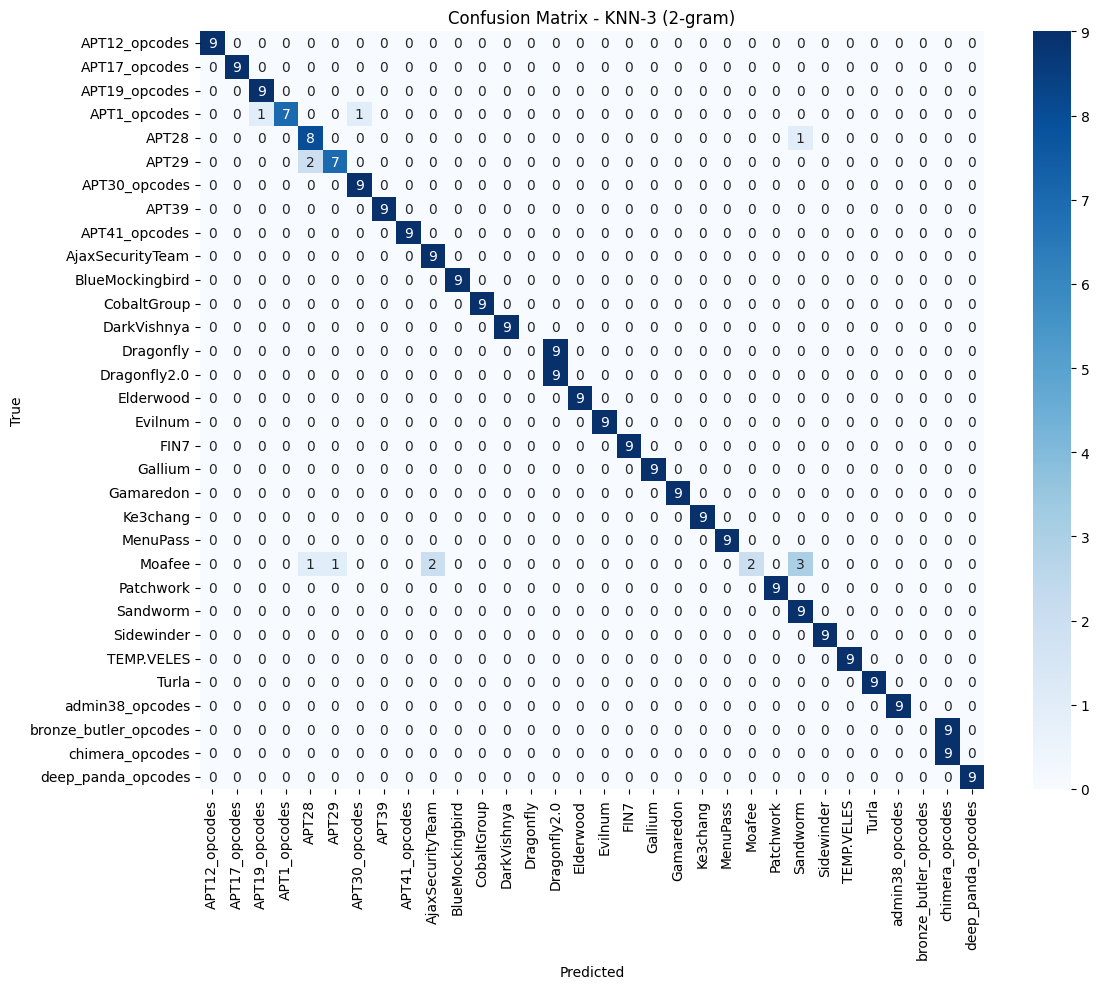

--------------------------------------------------------------------------------

KNN-5 Metrics:
--------------------------------------------------------------------------------
Accuracy: 0.8924
Precision: 0.8733
Recall: 0.8924
F1-Score: 0.8667

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00         9
        APT17_opcodes       1.00      1.00      1.00         9
        APT19_opcodes       0.90      1.00      0.95         9
         APT1_opcodes       1.00      0.78      0.88         9
                APT28       0.73      0.89      0.80         9
                APT29       1.00      0.78      0.88         9
        APT30_opcodes       0.90      1.00      0.95         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       1.00      1.00      1.00         9
     AjaxSecurityTeam       0.82      1.00      0.90         9
      BlueMockingbird       1.00     

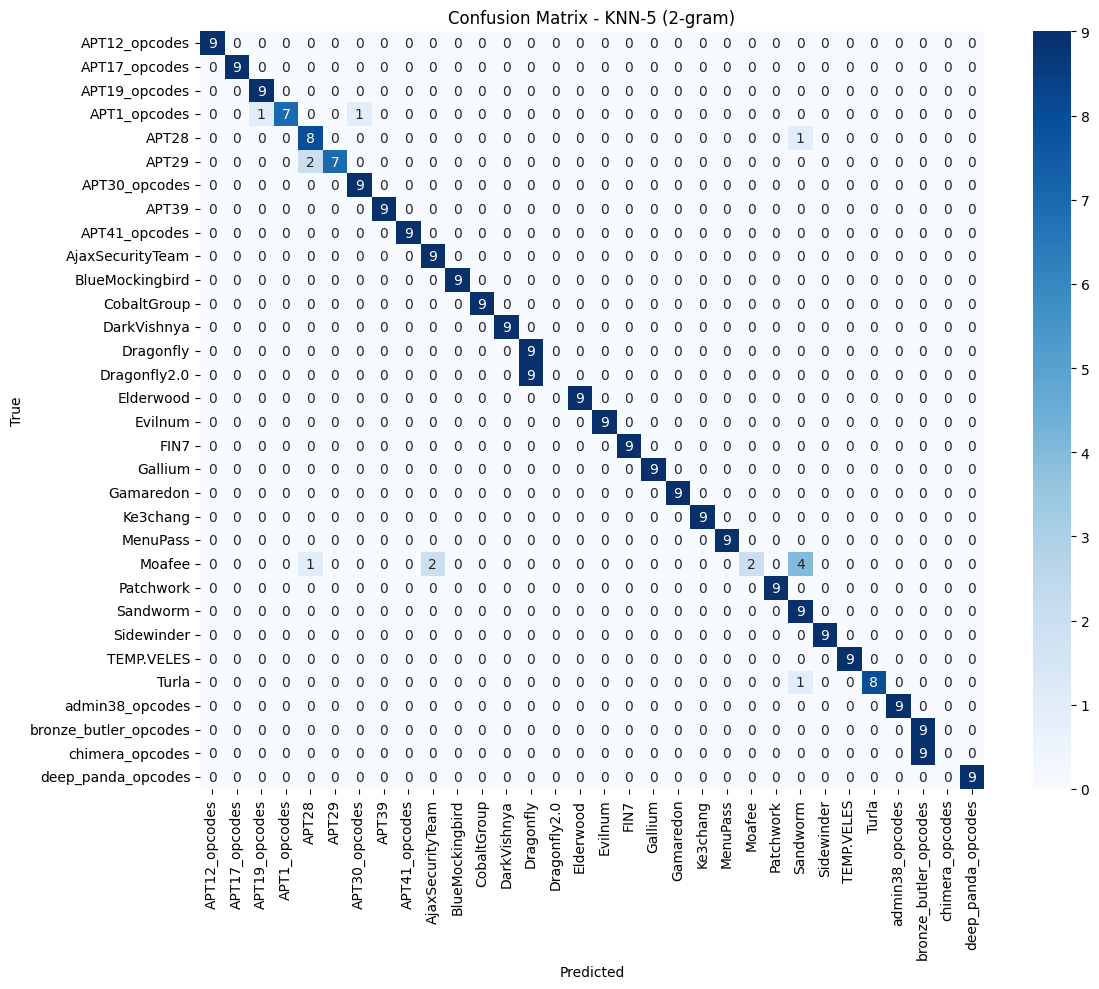

--------------------------------------------------------------------------------

Decision Tree Metrics:
--------------------------------------------------------------------------------
Accuracy: 0.4688
Precision: 0.4082
Recall: 0.4688
F1-Score: 0.4203

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00         9
        APT17_opcodes       0.06      1.00      0.12         9
        APT19_opcodes       0.00      0.00      0.00         9
         APT1_opcodes       0.00      0.00      0.00         9
                APT28       0.00      0.00      0.00         9
                APT29       0.00      0.00      0.00         9
        APT30_opcodes       0.00      0.00      0.00         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       0.00      0.00      0.00         9
     AjaxSecurityTeam       0.00      0.00      0.00         9
      BlueMockingbird       1

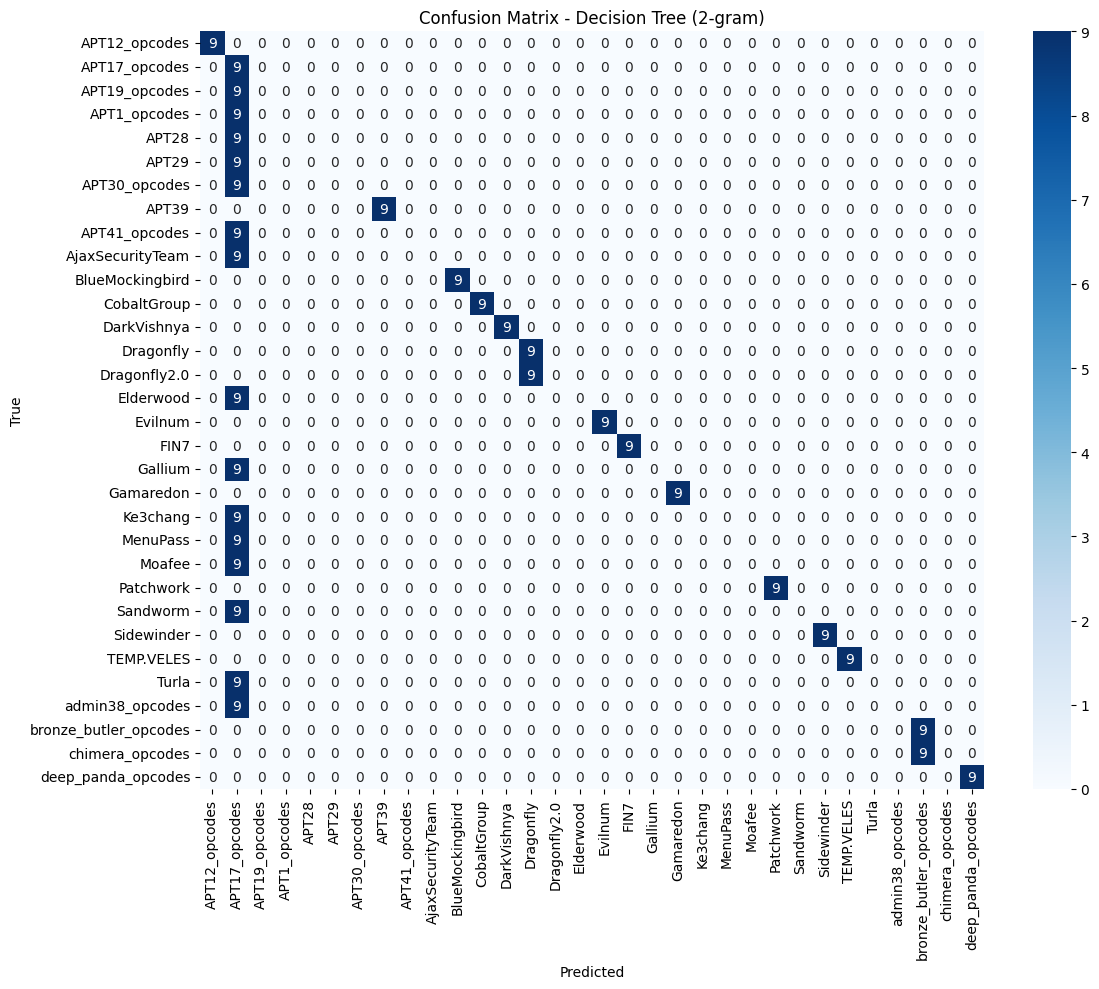

--------------------------------------------------------------------------------

======================================== Combined Results ========================================

SVM Metrics:
--------------------------------------------------------------------------------
Accuracy: 0.7361
Precision: 0.8595
Recall: 0.7361
F1-Score: 0.7188

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00         9
        APT17_opcodes       1.00      1.00      1.00         9
        APT19_opcodes       1.00      0.56      0.71         9
         APT1_opcodes       1.00      0.11      0.20         9
                APT28       1.00      0.22      0.36         9
                APT29       1.00      0.11      0.20         9
        APT30_opcodes       1.00      0.22      0.36         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       1.00      1.00      1.00         9
  

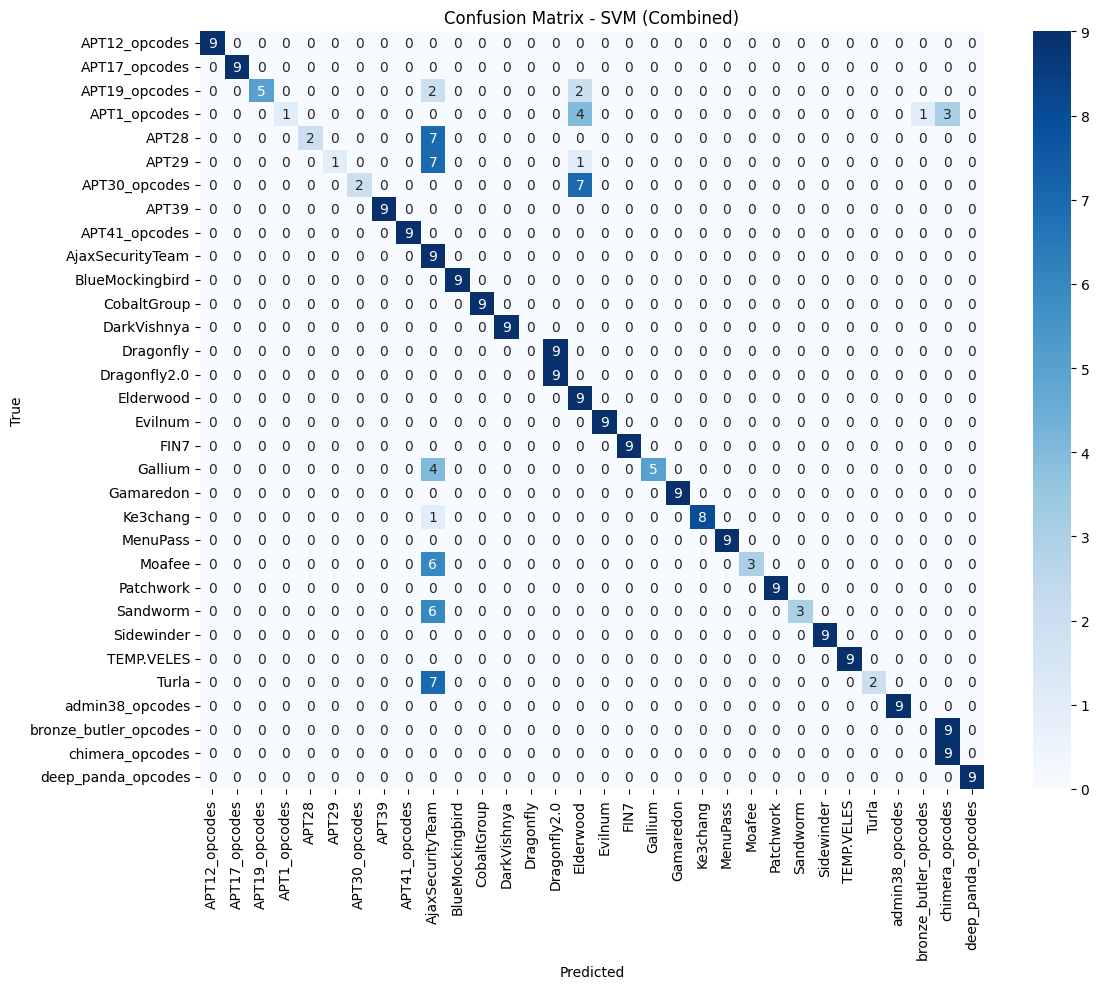

--------------------------------------------------------------------------------

KNN-3 Metrics:
--------------------------------------------------------------------------------
Accuracy: 0.8958
Precision: 0.8723
Recall: 0.8958
F1-Score: 0.8690

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00         9
        APT17_opcodes       1.00      1.00      1.00         9
        APT19_opcodes       0.90      1.00      0.95         9
         APT1_opcodes       1.00      0.78      0.88         9
                APT28       0.73      0.89      0.80         9
                APT29       0.88      0.78      0.82         9
        APT30_opcodes       0.90      1.00      0.95         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       1.00      1.00      1.00         9
     AjaxSecurityTeam       0.82      1.00      0.90         9
      BlueMockingbird       1.00     

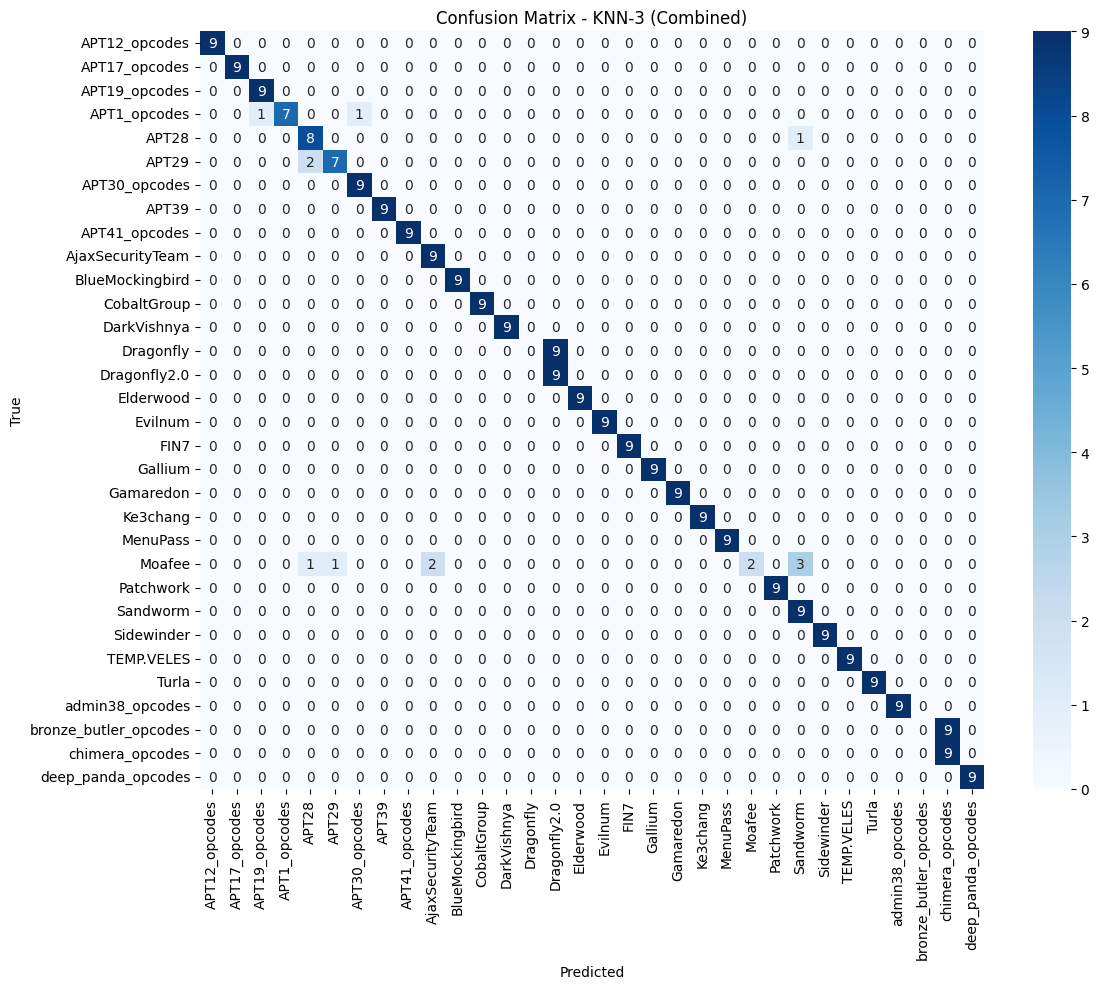

--------------------------------------------------------------------------------

KNN-5 Metrics:
--------------------------------------------------------------------------------
Accuracy: 0.8958
Precision: 0.8746
Recall: 0.8958
F1-Score: 0.8695

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00         9
        APT17_opcodes       1.00      1.00      1.00         9
        APT19_opcodes       0.90      1.00      0.95         9
         APT1_opcodes       1.00      0.78      0.88         9
                APT28       0.73      0.89      0.80         9
                APT29       1.00      0.78      0.88         9
        APT30_opcodes       0.90      1.00      0.95         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       1.00      1.00      1.00         9
     AjaxSecurityTeam       0.82      1.00      0.90         9
      BlueMockingbird       1.00     

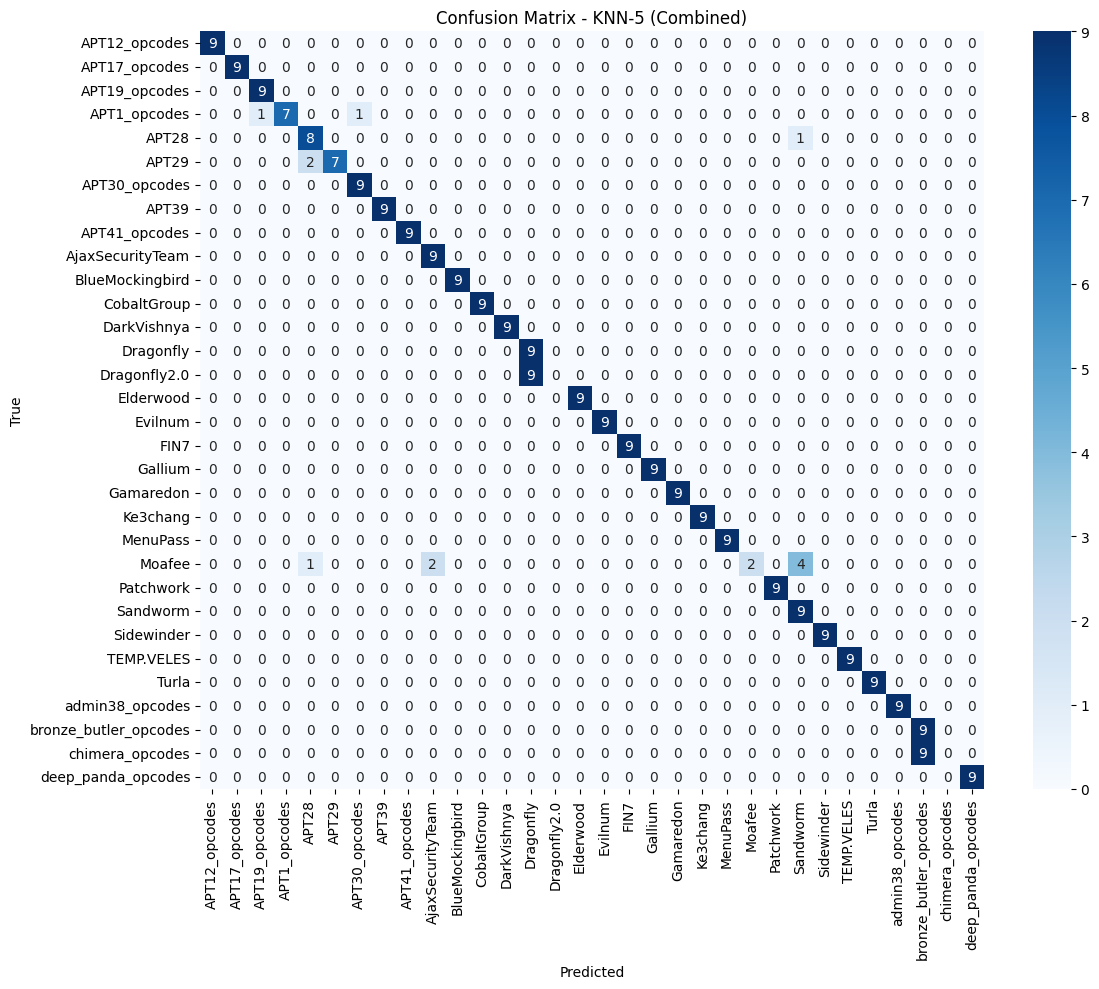

--------------------------------------------------------------------------------

Decision Tree Metrics:
--------------------------------------------------------------------------------
Accuracy: 0.5000
Precision: 0.3993
Recall: 0.5000
F1-Score: 0.4214

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       0.17      1.00      0.29         9
        APT17_opcodes       0.50      1.00      0.67         9
        APT19_opcodes       0.00      0.00      0.00         9
         APT1_opcodes       0.00      0.00      0.00         9
                APT28       0.11      1.00      0.20         9
                APT29       0.00      0.00      0.00         9
        APT30_opcodes       0.00      0.00      0.00         9
                APT39       1.00      1.00      1.00         9
        APT41_opcodes       0.00      0.00      0.00         9
     AjaxSecurityTeam       0.00      0.00      0.00         9
      BlueMockingbird       1

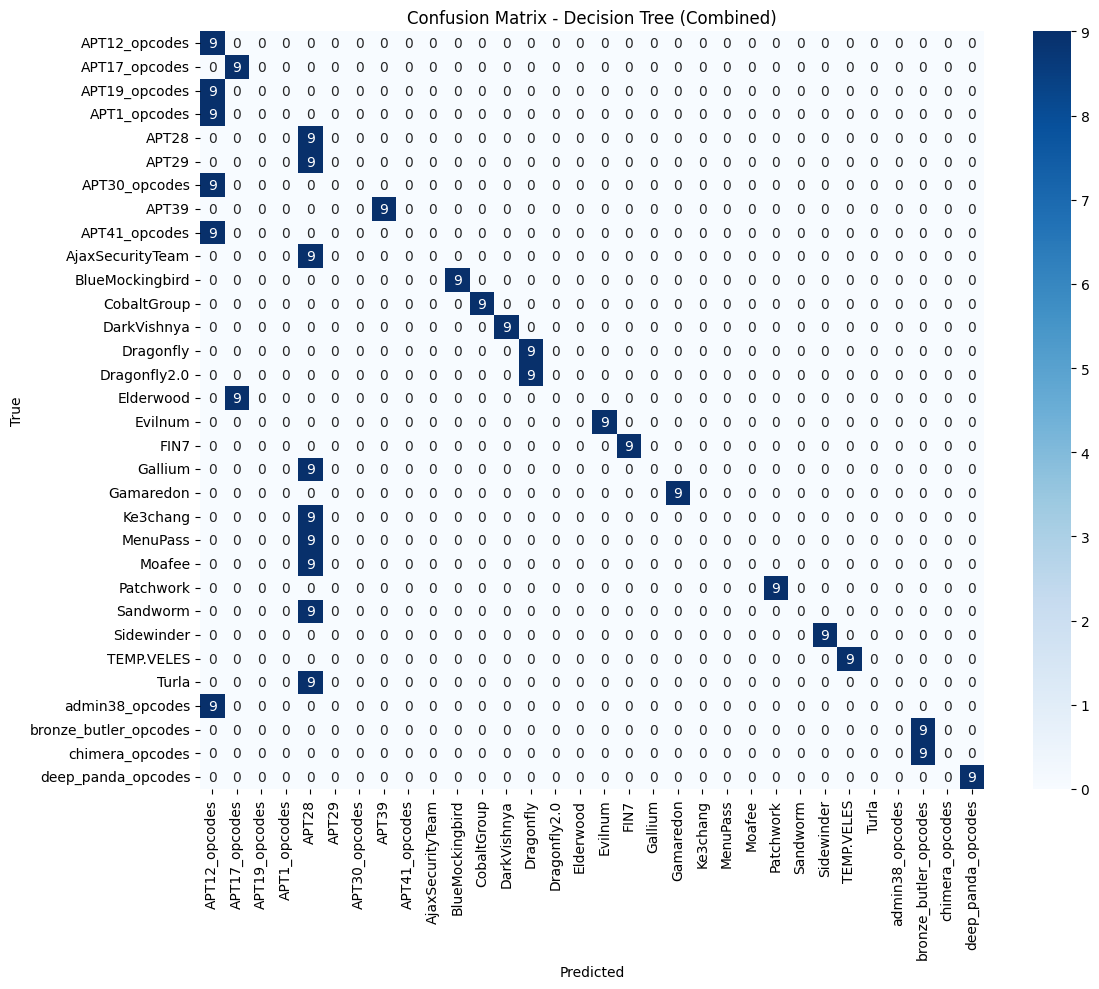

--------------------------------------------------------------------------------


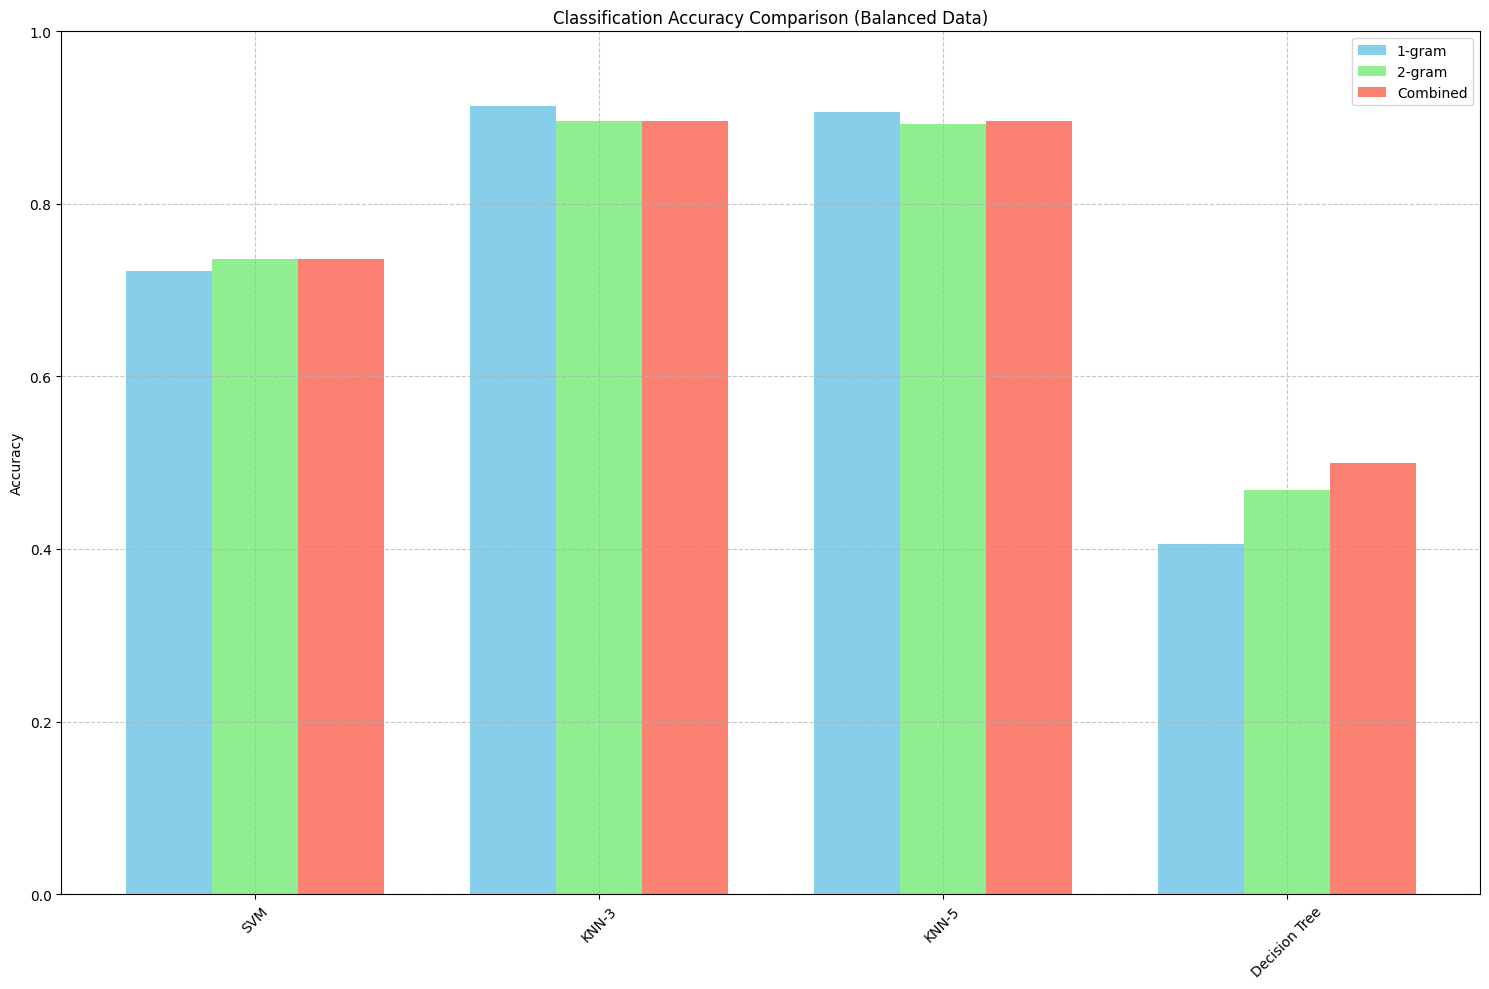

In [11]:
# Print detailed metrics for each feature type and classifier
feature_types = ['1-gram', '2-gram', 'Combined']
results_dict = {
    '1-gram': results_1gram,
    '2-gram': results_2gram,
    'Combined': results_combined
}

for feature_type in feature_types:
    print(f"\n{'='*40} {feature_type} Results {'='*40}")
    results = results_dict[feature_type]
    
    for clf_name, result in results.items():
        print(f"\n{clf_name} Metrics:")
        print("-" * 80)
        print(f"Accuracy: {result['accuracy']:.4f}")
        print(f"Precision: {result['precision']:.4f}")
        print(f"Recall: {result['recall']:.4f}")
        print(f"F1-Score: {result['f1']:.4f}")
        print("\nClassification Report:")
        print(result['report'])
        
        # Create confusion matrix plot
        plt.figure(figsize=(12, 10))
        cm = confusion_matrix(result['y_true'], result['y_pred'])
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=le.classes_, 
                   yticklabels=le.classes_)
        plt.title(f'Confusion Matrix - {clf_name} ({feature_type})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        print("-" * 80)

# Create summary comparison plot
plt.figure(figsize=(15, 10))
classifiers_list = ['SVM', 'KNN-3', 'KNN-5', 'Decision Tree']  # Define classifier names directly
x = np.arange(len(classifiers_list))
width = 0.25

# Plot accuracies
plt.bar(x - width, [results_1gram[clf]['accuracy'] for clf in classifiers_list], 
        width, label='1-gram', color='skyblue')
plt.bar(x, [results_2gram[clf]['accuracy'] for clf in classifiers_list], 
        width, label='2-gram', color='lightgreen')
plt.bar(x + width, [results_combined[clf]['accuracy'] for clf in classifiers_list], 
        width, label='Combined', color='salmon')

plt.ylabel('Accuracy')
plt.title('Classification Accuracy Comparison (Balanced Data)')
plt.xticks(x, classifiers_list, rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()